<a href="https://colab.research.google.com/github/ab2gbl/ECG-detection/blob/main/P_detection/P_detection_CNN%2BLSTM_70sample_MITDB_LUDB_QTDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!wget -r -N -c -np https://physionet.org/files/but-pdb/1.0.0/

In [ ]:
!wget -r -N -c -np https://physionet.org/files/pwave/1.0.0/

In [ ]:
!mkdir /content/physionet.org/
!mkdir /content/physionet.org/files/
!cp -r '/content/drive/MyDrive/Final project/dataset/physionet.org/files/ludb' '/content/physionet.org/files/'
!cp -r '/content/drive/MyDrive/Final project/dataset/physionet.org/files/qtdb' '/content/physionet.org/files/'

mkdir: cannot create directory ‘/content/physionet.org/’: File exists
mkdir: cannot create directory ‘/content/physionet.org/files/’: File exists


In [ ]:
!cp -r '/content/physionet.org/files/edb' '/content/drive/MyDrive/Final project/dataset/physionet.org/files/edb'


In [ ]:
!pip install wfdb numpy scipy matplotlib scikit-learn tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 87.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


# Gloabal variables

In [ ]:
G_window_size = 40
G_overlap = 35
G_fs = 360
G_q_offset = 14

# 1- Signal traitement functions

## 1-1- Preprocess the Signal

### A. Filtering

In [ ]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

def bandpass_filter(data, fs, lowcut=0.5, highcut=40.0, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    filtered = signal.filtfilt(b, a, data)
    return filtered

def differentiate_signal(data, fs):
    # Differentiate the signal using a first-order difference
    differentiated = np.diff(data, prepend=data[0])
    return differentiated

def smooth_signal(data, window_size=5):
    # Smooth the signal using a moving average filter
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(data, window, mode='same')
    return smoothed

from scipy.signal import resample
def resample_signal(signal, original_fs, target_fs=360):
    num_samples = int(len(signal) * target_fs / original_fs)
    resampled_signal = resample(signal, num_samples)
    return resampled_signal

def adjust_annotation(point, original_fs, target_fs):
    point = np.array(point)  # 🔥 Make sure it's a NumPy array
    return int((point * target_fs / original_fs).astype(int))

### B. Normalization

In [ ]:
def normalize_signal(data):
    """
    Normalize the signal using z-score normalization.
    """
    return (data - np.mean(data)) / np.std(data)


## 1-2- Segment the Signal for QRS Detection

In [ ]:
import numpy as np

def segment_signal(signal, window_size=G_window_size, overlap=G_overlap ):
    """
    Segment the signal into fixed-length windows with a specified overlap.

    Args:
        signal (np.array): The input signal.
        window_size (int): Length of each segment (in samples).
        overlap (int): Number of overlapping samples between consecutive segments.

    Returns:
        tuple: (Array of segmented windows, Array of segment start indices)
    """
    segments = []
    segment_indices = []

    step = window_size - overlap  # Step size for sliding window
    for start in range(0, len(signal) - window_size + 1, step):
        end = start + window_size
        segments.append(signal[start:end])
        segment_indices.append(start)  # Store segment start position

    return np.array(segments), np.array(segment_indices)




## 1-3- Labeling and Combining the Data

In [ ]:
import numpy as np

def label_segments(normalized_signal,segments, segment_starts, qrs_indices, q_offset=G_q_offset, window_size=G_window_size, overlap=G_overlap):
    """
    Label each segment as QRS (1) or non-QRS (0), ensuring an equal number of 0 and 1 labels.

    Args:
        segments (np.array): Array of segmented windows.
        segment_starts (np.array): Start indices of segments.
        qrs_indices (list): List of QRS indices (in samples).
        window_size (int): Length of each segment (in samples).
        overlap (int): Number of overlapping samples between consecutive segments.

    Returns:
        np.array: Array of labels (1 for QRS, 0 for non-QRS).
    """
    labels = np.zeros(len(segments), dtype=int)

    # Label QRS segments
    for i, segment_start in enumerate(segment_starts):
        segment_end = segment_start + window_size

        # Check if any QRS index falls within this segment
        for r_peak in qrs_indices:
            q_start = r_peak - q_offset  # Approximate Q start
            s_end = r_peak + q_offset    # Approximate S end

            # Ensure q_start and s_end are within bounds
            q_start = max(0, q_start)
            s_end = min(len(normalized_signal) - 1, s_end)

            if segment_start <= q_start and segment_end >= s_end:
                labels[i] = 1
                break

    # Balance the dataset by randomly sampling non-QRS segments
    qrs_count = np.sum(labels == 1)  # Number of QRS segments
    non_qrs_indices = np.where(labels == 0)[0]  # Indices of non-QRS segments

    # Randomly sample non-QRS segments to match the number of QRS segments
    if len(non_qrs_indices) > qrs_count:
        sampled_non_qrs_indices = np.random.choice(non_qrs_indices, size=qrs_count, replace=False)
        labels[sampled_non_qrs_indices] = 0  # Ensure sampled non-QRS segments are labeled as 0
    else:
        print("Warning: Not enough non-QRS segments to balance the dataset.")

    return labels




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def display_segment(normalized_signal,segment_labels,segment_starts,z_start,z_end):
  # Define sampling rate

  # Define zoom window in **seconds**
  zoom_start_sec = z_start   # Start time in seconds
  zoom_end_sec = z_end     # End time in seconds

  # Convert zoom window from seconds to samples
  zoom_start = zoom_start_sec * G_fs  # Convert to sample index
  zoom_end = zoom_end_sec * G_fs      # Convert to sample index

  # Function to filter windows within the zoom range (in sample indices)
  def filter_windows_in_zoom(windows, zoom_start, zoom_end):
      """Filter windows that fall within the zoom range in samples."""
      return [(start, end) for start, end in windows if start < zoom_end and end > zoom_start]

  # Identify segment start and end in samples
  positive_windows = [(segment_starts[i], segment_starts[i] + G_window_size) for i in range(len(segment_labels)) if segment_labels[i] == 1]
  negative_windows = [(segment_starts[i], segment_starts[i] + G_window_size) for i in range(len(segment_labels)) if segment_labels[i] == 0]
  print("Number of positive (QRS) segments:", len(positive_windows))
  print("Number of negative (non-QRS) segments:", len(negative_windows))
  # Filter positive and negative windows within the zoom range
  positive_windows_zoom = filter_windows_in_zoom(positive_windows, zoom_start, zoom_end)
  negative_windows_zoom = filter_windows_in_zoom(negative_windows, zoom_start, zoom_end)

  # Create time axis in **seconds**
  time_axis = np.arange(len(normalized_signal)) / G_fs  # Convert samples to seconds

  # Plot 1: Positive (QRS) Segments
  plt.figure(figsize=(12, 4))
  plt.plot(time_axis, normalized_signal, label="ECG Signal", color="blue")

  # Highlight positive (QRS) windows in red (only within the zoom range)
  for start, end in positive_windows_zoom:
      plt.axvspan(start / G_fs, end / G_fs, color="red", alpha=0.3, label="QRS Segment" if start == positive_windows_zoom[0][0] else "")

  plt.title(f"Positive (QRS) Segments (Window Size: {G_window_size} samples, Overlap: {G_overlap} samples)")
  plt.xlabel("Time (s)")
  plt.ylabel("Normalized Amplitude")
  plt.xlim(zoom_start_sec, zoom_end_sec)  # Zoom in on the time range
  plt.legend()
  plt.grid()
  plt.show()

  # Plot 2: Negative (Non-QRS) Segments
  plt.figure(figsize=(12, 4))
  plt.plot(time_axis, normalized_signal, label="ECG Signal", color="blue")

  # Highlight negative (non-QRS) windows in yellow (only within the zoom range)
  for start, end in negative_windows_zoom:
      plt.axvspan(start / G_fs, end / G_fs, color="yellow", alpha=0.3, label="Non-QRS Segment" if start == negative_windows_zoom[0][0] else "")
      #plt.vlines(start / G_fs, ymin=np.min(normalized_signal), ymax=np.max(normalized_signal), color="green", linestyle="dashed", alpha=0.6, label="Segment Start")

  plt.title(f"Negative (Non-QRS) Segments (Window Size: {G_window_size} samples, Overlap: {G_overlap} samples)")
  plt.xlabel("Time (s)")
  plt.ylabel("Normalized Amplitude")
  plt.xlim(zoom_start_sec, zoom_end_sec)  # Zoom in on the time range
  plt.legend()
  plt.grid()
  plt.show()


## 1-4. traitement sigments

In [ ]:

def remove_consecutive_ones(segment_labels, segmented_signal, segment_starts):
    filtered_labels = []
    filtered_signal = []
    filtered_starts = []

    i = 0


    while i < len(segment_labels)-1:
        if segment_labels[i] == 1:
            # Find the range of consecutive ones
            start = i
            while i + 1 < len(segment_labels) and segment_labels[i + 1] == 1:
                i += 1
            end = i

            # Compute the middle index of the block
            mid = (start + end) // 2
            #mid =  end


            # Keep only the middle one
            filtered_labels.append(segment_labels[mid])
            filtered_signal.append(segmented_signal[mid])
            filtered_starts.append(segment_starts[mid])

        else:
            # Keep zeros as they are
            filtered_labels.append(segment_labels[i])
            filtered_signal.append(segmented_signal[i])
            filtered_starts.append(segment_starts[i])

        i += 1  # Move to the next segment

    return filtered_labels, filtered_signal, filtered_starts

In [ ]:
def trim_to_ones(segment_labels, segmented_signal, segment_starts):
    # Find indices of all the '1's
    ones_indices = [i for i, label in enumerate(segment_labels) if label == 1]

    if not ones_indices:
        # No '1's found, return empty lists
        return [], [], []

    # Determine start and end range to keep
    first_one = ones_indices[0]
    last_one = ones_indices[-1]

    # Slice the arrays to keep only data between first and last 1 (inclusive)
    filtered_labels = segment_labels[first_one:last_one + 1]
    filtered_signal = segmented_signal[first_one:last_one + 1]
    filtered_starts = segment_starts[first_one:last_one + 1]

    return filtered_labels, filtered_signal, filtered_starts


In [ ]:
def remove_touching_negatives(segment_labels, segmented_signal, segment_starts):
    new_labels = segment_labels[:]  # Copy original lists
    new_signal = segmented_signal[:]
    new_starts = segment_starts[:]

    step = G_window_size - G_overlap  # Compute the step size
    num_windows = max(1, round(G_window_size / step))-1 # Number of windows to remove (ensure at least 1)
    to_remove = set()  # Indices to remove

    for i, label in enumerate(segment_labels):
        if label == 1:  # If it's a positive window
            # Mark 4 windows before and after for removal
            for j in range(max(0, i - num_windows), min(len(segment_labels), i + num_windows + 1)):
                if segment_labels[j] == 0:  # Only remove negatives
                    to_remove.add(j)

    # Remove marked indices
    new_labels = [label for i, label in enumerate(segment_labels) if i not in to_remove]
    new_signal = [signal for i, signal in enumerate(segmented_signal) if i not in to_remove]
    new_starts = [start for i, start in enumerate(segment_starts) if i not in to_remove]

    return new_labels, new_signal, new_starts



In [ ]:
import random

def balance_classes(segment_labels, segmented_signal, segment_starts):
    # Count positive and negative instances
    num_positives = sum(1 for label in segment_labels if label == 1)
    num_negatives = sum(1 for label in segment_labels if label == 0)

    # If negatives are already balanced, return as is
    if num_negatives <= num_positives:
        return segment_labels, segmented_signal, segment_starts

    # Get indices of negative samples
    negative_indices = [i for i, label in enumerate(segment_labels) if label == 0]

    # Randomly select indices to remove
    num_to_remove = num_negatives - num_positives
    indices_to_remove = set(random.sample(negative_indices, num_to_remove))

    # Remove selected negatives while keeping lists synchronized
    new_labels = [label for i, label in enumerate(segment_labels) if i not in indices_to_remove]
    new_signal = [signal for i, signal in enumerate(segmented_signal) if i not in indices_to_remove]
    new_starts = [start for i, start in enumerate(segment_starts) if i not in indices_to_remove]

    return new_labels, new_signal, new_starts



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def display_segment(normalized_signal,segment_labels,segment_starts,z_start,z_end):
  # Define sampling rate

  # Define zoom window in **seconds**
  zoom_start_sec = z_start   # Start time in seconds
  zoom_end_sec = z_end     # End time in seconds

  # Convert zoom window from seconds to samples
  zoom_start = zoom_start_sec * G_fs  # Convert to sample index
  zoom_end = zoom_end_sec * G_fs      # Convert to sample index

  # Function to filter windows within the zoom range (in sample indices)
  def filter_windows_in_zoom(windows, zoom_start, zoom_end):
      """Filter windows that fall within the zoom range in samples."""
      return [(start, end) for start, end in windows if start < zoom_end and end > zoom_start]

  # Identify segment start and end in samples
  positive_windows = [(segment_starts[i], segment_starts[i] + G_window_size) for i in range(len(segment_labels)) if segment_labels[i] == 1]
  negative_windows = [(segment_starts[i], segment_starts[i] + G_window_size) for i in range(len(segment_labels)) if segment_labels[i] == 0]
  print("Number of positive (QRS) segments:", len(positive_windows))
  print("Number of negative (non-QRS) segments:", len(negative_windows))
  # Filter positive and negative windows within the zoom range
  positive_windows_zoom = filter_windows_in_zoom(positive_windows, zoom_start, zoom_end)
  negative_windows_zoom = filter_windows_in_zoom(negative_windows, zoom_start, zoom_end)

  # Create time axis in **seconds**
  time_axis = np.arange(len(normalized_signal)) / G_fs  # Convert samples to seconds

  # Plot 1: Positive (QRS) Segments
  plt.figure(figsize=(12, 4))
  plt.plot(time_axis, normalized_signal, label="ECG Signal", color="blue")

  # Highlight positive (QRS) windows in red (only within the zoom range)
  for start, end in positive_windows_zoom:
      plt.axvspan(start / G_fs, end / G_fs, color="red", alpha=0.3, label="QRS Segment" if start == positive_windows_zoom[0][0] else "")

  plt.title(f"Positive (QRS) Segments (Window Size: {G_window_size} samples, Overlap: {G_overlap} samples)")
  plt.xlabel("Time (s)")
  plt.ylabel("Normalized Amplitude")
  plt.xlim(zoom_start_sec, zoom_end_sec)  # Zoom in on the time range
  plt.legend()
  plt.grid()
  plt.show()

  # Plot 2: Negative (Non-QRS) Segments
  plt.figure(figsize=(12, 4))
  plt.plot(time_axis, normalized_signal, label="ECG Signal", color="blue")

  # Highlight negative (non-QRS) windows in yellow (only within the zoom range)
  for start, end in negative_windows_zoom:
      plt.axvspan(start / G_fs, end / G_fs, color="yellow", alpha=0.3, label="Non-QRS Segment" if start == negative_windows_zoom[0][0] else "")
      #plt.vlines(start / G_fs, ymin=np.min(normalized_signal), ymax=np.max(normalized_signal), color="green", linestyle="dashed", alpha=0.6, label="Segment Start")

  plt.title(f"Negative (Non-QRS) Segments (Window Size: {G_window_size} samples, Overlap: {G_overlap} samples)")
  plt.xlabel("Time (s)")
  plt.ylabel("Normalized Amplitude")
  plt.xlim(zoom_start_sec, zoom_end_sec)  # Zoom in on the time range
  plt.legend()
  plt.grid()
  plt.show()


# 2- preparing signals

Processing record: data/1 from ludb
Number of positive (QRS) segments: 5
Number of negative (non-QRS) segments: 5


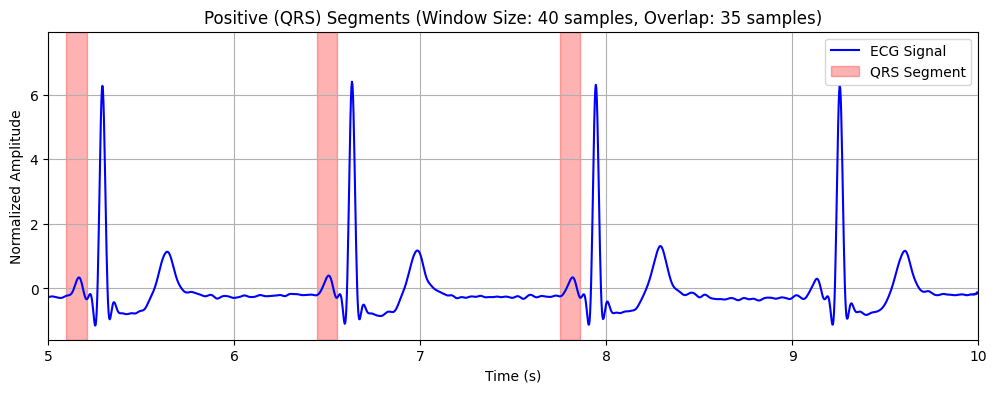

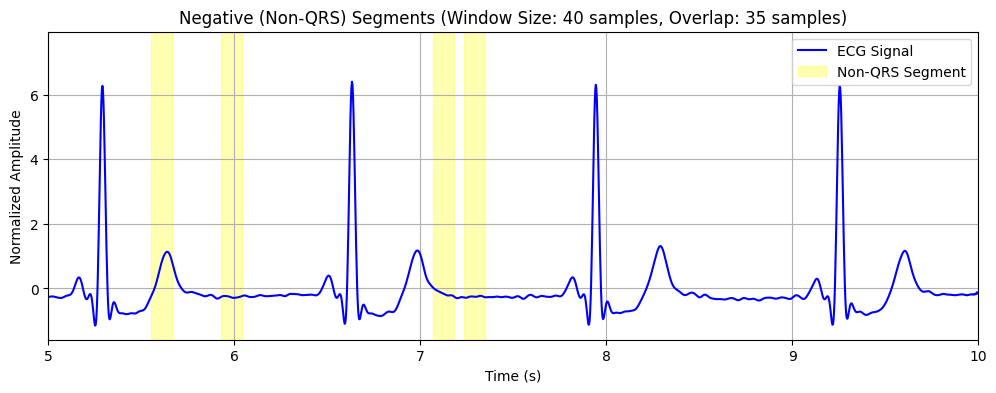

data/1 positive: 5, negative: 5
Processing record: data/2 from ludb
data/2 positive: 8, negative: 8
Processing record: data/3 from ludb
data/3 positive: 8, negative: 8
Processing record: data/4 from ludb
data/4 positive: 8, negative: 8
Processing record: data/5 from ludb
data/5 positive: 6, negative: 6
Processing record: data/6 from ludb
data/6 positive: 6, negative: 6
Processing record: data/7 from ludb
data/7 positive: 7, negative: 7
Processing record: data/8 from ludb
data/8 positive: 0, negative: 0
Processing record: data/9 from ludb
data/9 positive: 8, negative: 8
Processing record: data/10 from ludb
data/10 positive: 6, negative: 6
Processing record: data/11 from ludb
data/11 positive: 7, negative: 7
Processing record: data/12 from ludb
data/12 positive: 6, negative: 6
Processing record: data/13 from ludb
data/13 positive: 6, negative: 6
Processing record: data/14 from ludb
data/14 positive: 11, negative: 11
Processing record: data/15 from ludb
data/15 positive: 7, negative: 7
Pr

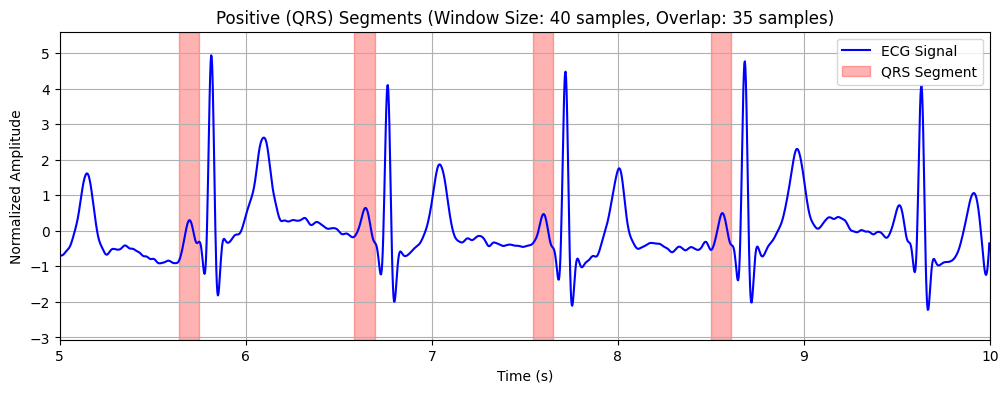

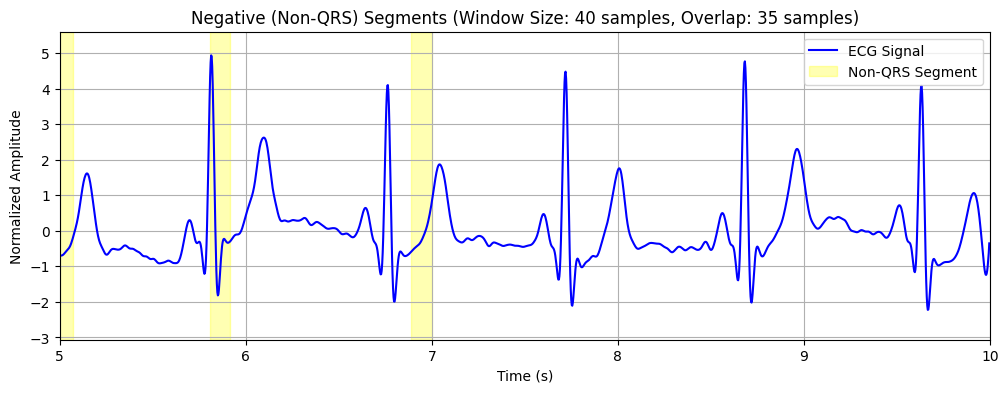

data/200 positive: 8, negative: 8
Processing record: sel100 from qtdb
Number of positive (QRS) segments: 1129
Number of negative (non-QRS) segments: 1129


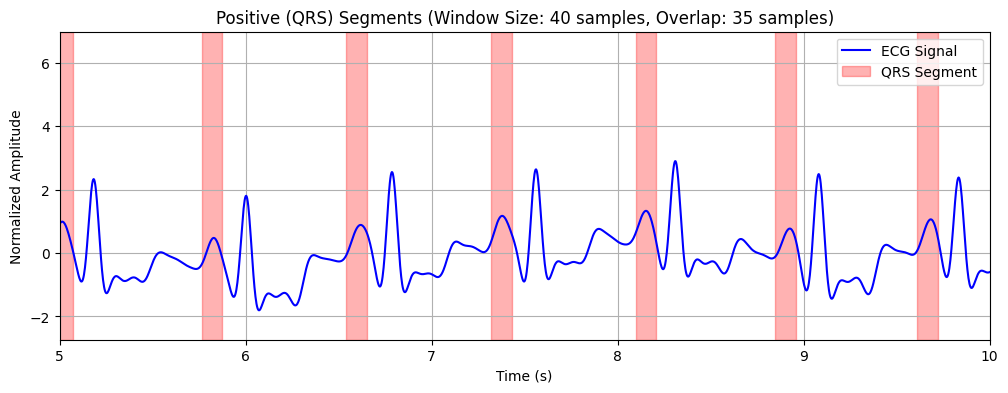

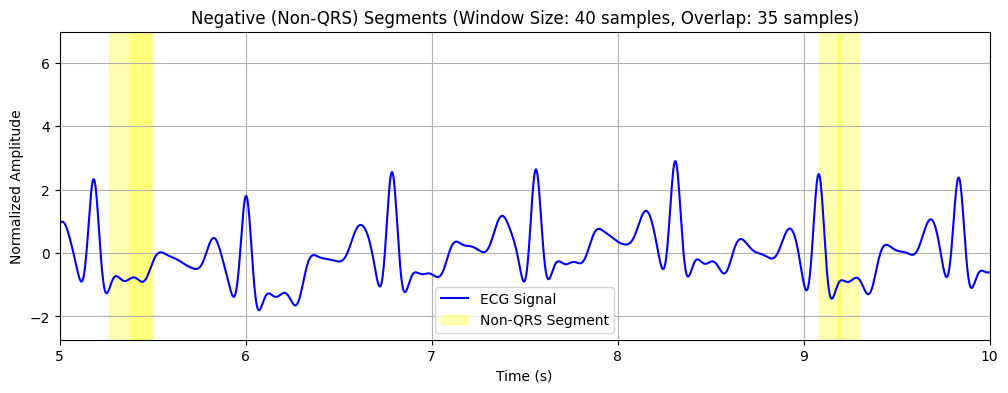

sel100 positive: 1129, negative: 1129
Processing record: sel102 from qtdb
sel102 positive: 378, negative: 378
Processing record: sel103 from qtdb
sel103 positive: 1047, negative: 1047
Processing record: sel104 from qtdb
sel104 positive: 341, negative: 341
Processing record: sel114 from qtdb
sel114 positive: 817, negative: 817
Processing record: sel116 from qtdb
sel116 positive: 1019, negative: 1019
Processing record: sel117 from qtdb
sel117 positive: 765, negative: 765
Processing record: sel123 from qtdb
sel123 positive: 751, negative: 751
Processing record: sel14046 from qtdb
sel14046 positive: 885, negative: 885
Processing record: sel14157 from qtdb
sel14157 positive: 910, negative: 910
Processing record: sel14172 from qtdb
sel14172 positive: 659, negative: 659
Processing record: sel15814 from qtdb
sel15814 positive: 1006, negative: 1006
Processing record: sel16265 from qtdb
sel16265 positive: 712, negative: 712
Processing record: sel16272 from qtdb
sel16272 positive: 846, negative: 

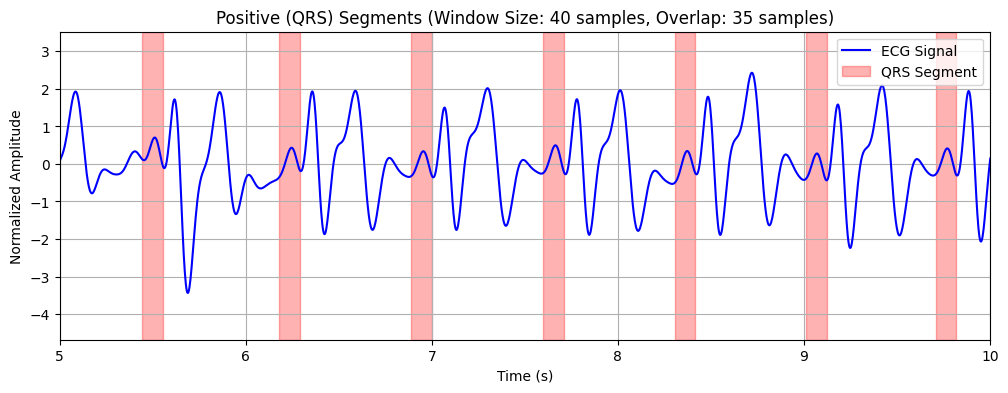

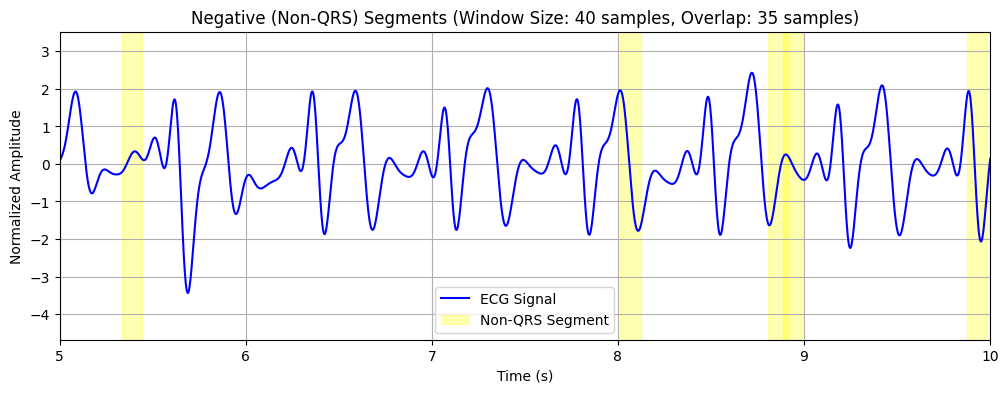

sele0704 positive: 1092, negative: 1092
Processing record: 100 from pwave
Number of positive (QRS) segments: 2257
Number of negative (non-QRS) segments: 2257


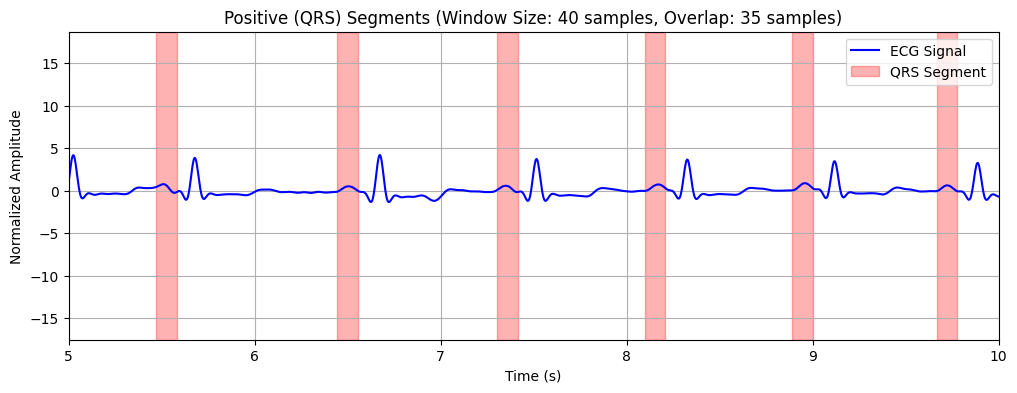

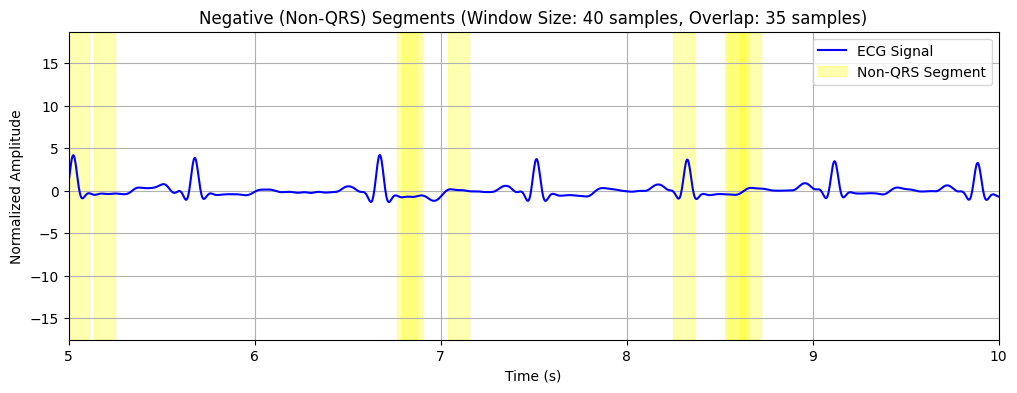

100 positive: 2257, negative: 2257
Processing record: 101 from pwave
101 positive: 1865, negative: 1865
Processing record: 103 from pwave
103 positive: 2084, negative: 2084
Processing record: 106 from pwave
106 positive: 1507, negative: 1507
Processing record: 117 from pwave
117 positive: 1534, negative: 1534
Processing record: 119 from pwave
119 positive: 1543, negative: 1543
Processing record: 122 from pwave
122 positive: 2475, negative: 2475
Processing record: 207 from pwave
207 positive: 1415, negative: 1415
Processing record: 214 from pwave
214 positive: 2000, negative: 2000
Processing record: 222 from pwave
222 positive: 1257, negative: 1257
Processing record: 223 from pwave
223 positive: 2099, negative: 2099
Processing record: 231 from pwave
Number of positive (QRS) segments: 1994
Number of negative (non-QRS) segments: 1994


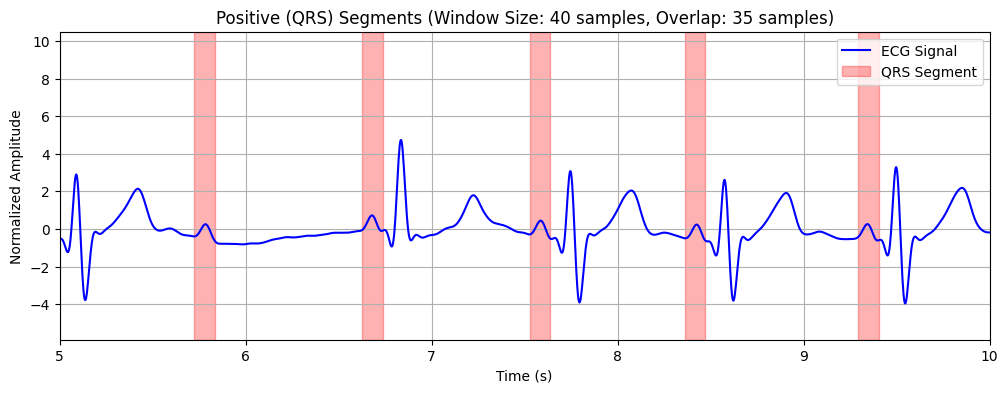

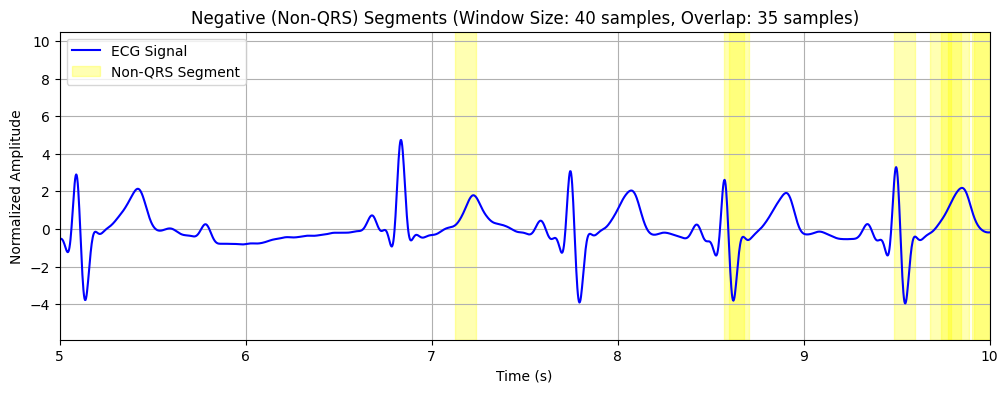

231 positive: 1994, negative: 1994
Processing record: 01 from but-pdb
Number of positive (QRS) segments: 0
Number of negative (non-QRS) segments: 0


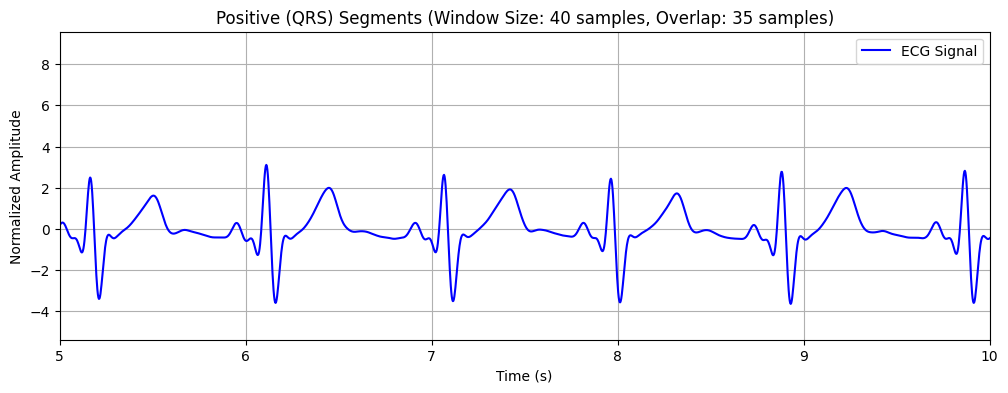

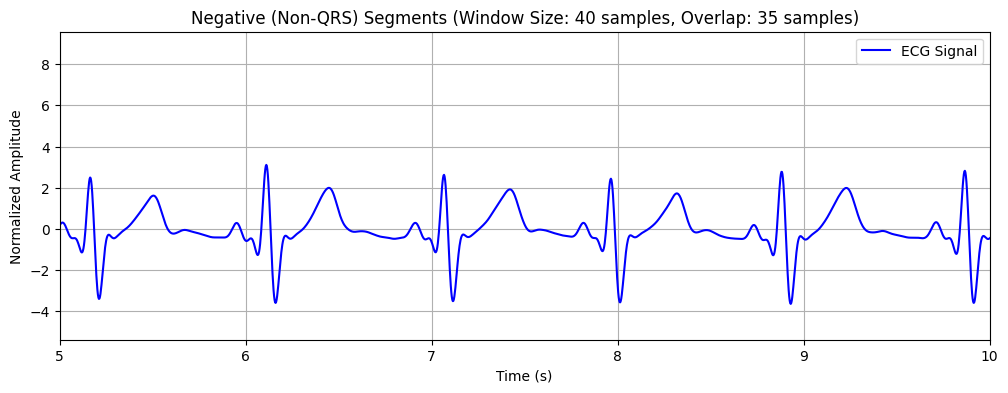

01 positive: 0, negative: 0
Processing record: 02 from but-pdb
02 positive: 0, negative: 0
Processing record: 03 from but-pdb
03 positive: 0, negative: 0
Processing record: 04 from but-pdb
04 positive: 0, negative: 0
Processing record: 05 from but-pdb
05 positive: 0, negative: 0
Processing record: 06 from but-pdb
06 positive: 0, negative: 0
Processing record: 07 from but-pdb
07 positive: 0, negative: 0
Processing record: 08 from but-pdb
08 positive: 0, negative: 0
Processing record: 09 from but-pdb
09 positive: 0, negative: 0
Processing record: 10 from but-pdb
10 positive: 0, negative: 0
Processing record: 11 from but-pdb
11 positive: 0, negative: 0
Processing record: 12 from but-pdb
12 positive: 0, negative: 0
Processing record: 13 from but-pdb
13 positive: 0, negative: 0
Processing record: 14 from but-pdb
14 positive: 0, negative: 0
Processing record: 15 from but-pdb
15 positive: 0, negative: 0
Processing record: 16 from but-pdb
16 positive: 0, negative: 0
Processing record: 17 from 

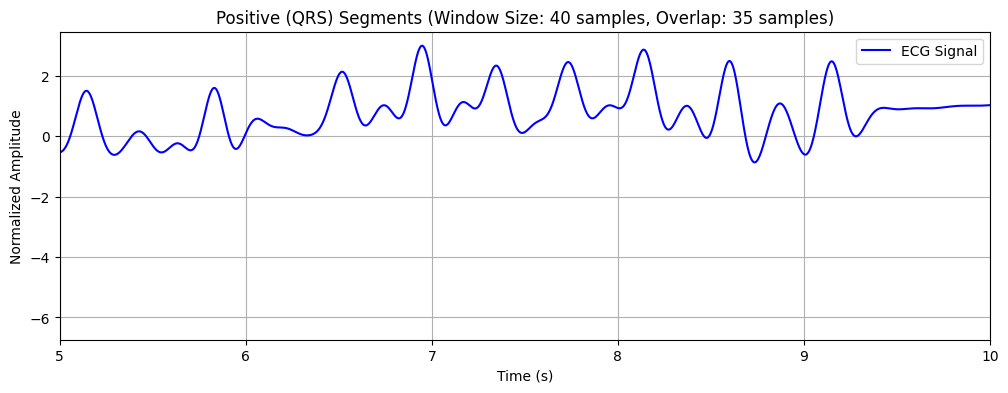

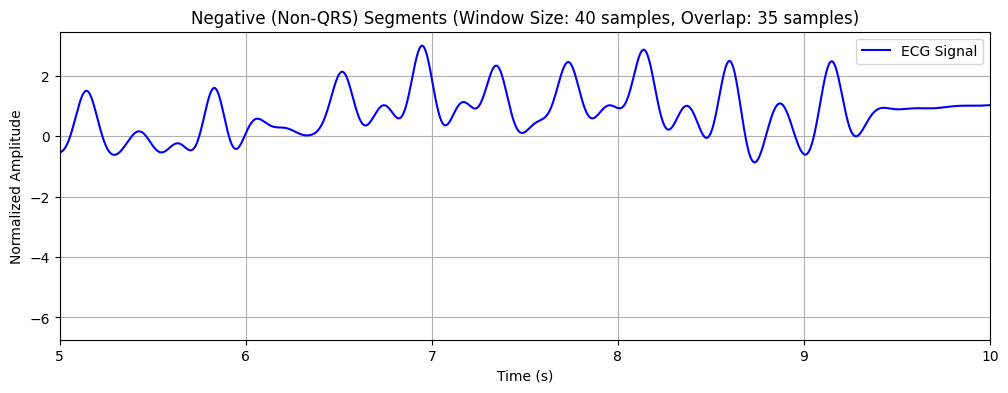

50 positive: 0, negative: 0
Total segments collected: 241096


In [ ]:
import wfdb
import numpy as np
from scipy.signal import resample

import wfdb
import numpy as np
from scipy.signal import resample

# Define record directories
db_paths = {
    'ludb': '/content/physionet.org/files/ludb/1.0.1/',
    #'mitdb': '/content/physionet.org/files/mitdb/1.0.0/',
    'qtdb': '/content/physionet.org/files/qtdb/1.0.0/',
    'pwave' : '/content/physionet.org/files/pwave/1.0.0/',
    'but-pdb' : '/content/physionet.org/files/but-pdb/1.0.0/'

}

# Fetch record lists
record_lists = {
    db: wfdb.get_record_list(db) for db in db_paths
}

for i in range(9):
  record_lists['but-pdb'][i]='0'+record_lists['but-pdb'][i]

# Initialize accumulators
all_segments = []
all_segment_labels = []
all_segment_starts = []

# Process all records in all databases
for db_name, record_dir in db_paths.items():
    for record_name in record_lists[db_name]:
        print(f"Processing record: {record_name} from {db_name}")

        # Load signal
        record = wfdb.rdrecord(record_dir + record_name)
        try:
          if db_name == 'ludb' :
            annotation = wfdb.rdann(record_dir + record_name, 'i')
          elif db_name == 'qtdb' :
            annotation = wfdb.rdann(record_dir + record_name, 'pu0')
          else :
            annotation = wfdb.rdann(record_dir + record_name, 'pwave')
        except:
            print(f"No annotation found for {record_name}, skipping.")
            continue

        ecg_signal = record.p_signal[:, 0]
        G_fs = record.fs

        time_axis = np.arange(0, len(ecg_signal)) / G_fs

        # Apply bandpass filter and smoothing
        filtered_signal = bandpass_filter(ecg_signal, 1000)
        smoothed_signal = smooth_signal(filtered_signal, window_size=5)

        # Normalize and segment
        normalized_signal = normalize_signal(smoothed_signal)
        # Extract annotation labels (adjust if needed for LUDB/QTDB)
        if db_name == 'but-pdb':
          qrs_symbols = ['N']
        else :
          qrs_symbols = ['p']

        qrs_indices = [s for s, sym in zip(annotation.sample, annotation.symbol) if sym in qrs_symbols]

        if G_fs != 360:
            normalized_signal = resample_signal(normalized_signal, original_fs=G_fs, target_fs=360)
            qrs_indices = [adjust_annotation(point, original_fs=G_fs, target_fs=360) for point in qrs_indices]
            G_fs = 360

        # Segment the normalized signal
        segmented_signal, segment_starts = segment_signal(normalized_signal, window_size=G_window_size, overlap=G_overlap)


        # Label and clean
        segment_labels = label_segments(normalized_signal, segmented_signal, segment_starts, qrs_indices, q_offset=G_q_offset, window_size=G_window_size, overlap=G_overlap)
        segment_labels, segmented_signal, segment_starts = remove_consecutive_ones(segment_labels, segmented_signal, segment_starts)
        segment_labels, segmented_signal, segment_starts = trim_to_ones(segment_labels, segmented_signal, segment_starts)
        segment_labels, segmented_signal, segment_starts = remove_touching_negatives(segment_labels, segmented_signal, segment_starts)
        #display_segment(normalized_signal,segment_labels,segment_starts,0,10)
        segment_labels, segmented_signal, segment_starts = balance_classes(segment_labels, segmented_signal, segment_starts)
        if record_name==record_lists[db_name][-1] or record_name==record_lists[db_name][0]:
          display_segment(normalized_signal,segment_labels,segment_starts,5,10)
        print(f"{record_name} positive: {np.sum(np.array(segment_labels) == 1)}, negative: {np.sum(np.array(segment_labels) == 0)}")

        '''
        np.savez("/content/drive/MyDrive/Final project/QRS detection/segments/"+record_name+" from "+db_name+" segment 70s 65o 33q.npz",
                segments=np.array(segmented_signal, dtype=object),
                labels=np.array(segment_labels),
                starts=np.array(segment_starts))
        '''
        # Store all data
        all_segments.extend(segmented_signal)
        all_segment_labels.extend(segment_labels)
        all_segment_starts.extend(segment_starts)

print(f"Total segments collected: {len(all_segments)}")

Processing record: 01 from but-pdb
Number of positive (QRS) segments: 132
Number of negative (non-QRS) segments: 132


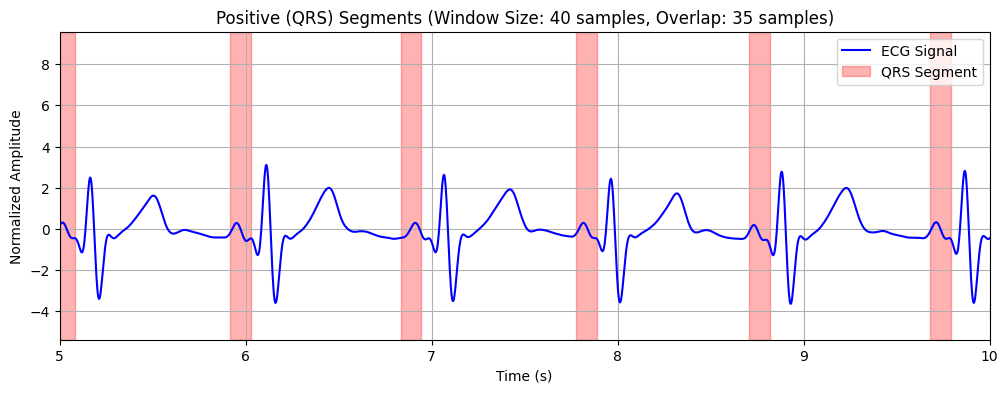

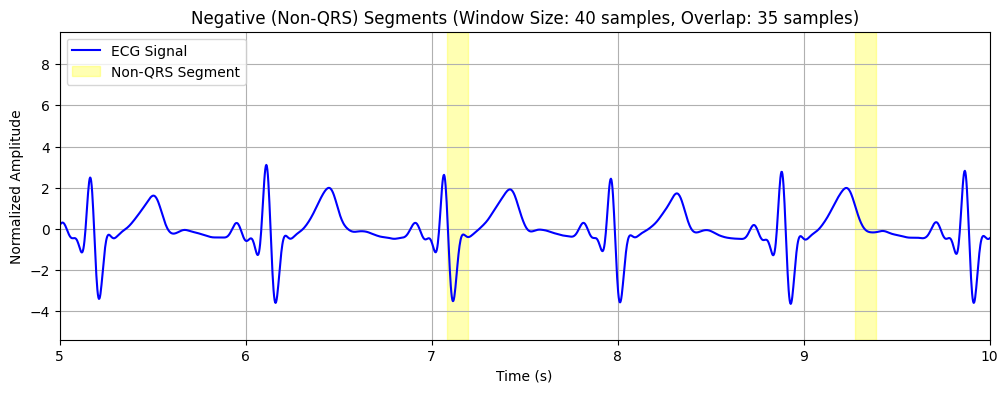

01 positive: 132, negative: 132
Processing record: 02 from but-pdb
Number of positive (QRS) segments: 81
Number of negative (non-QRS) segments: 81


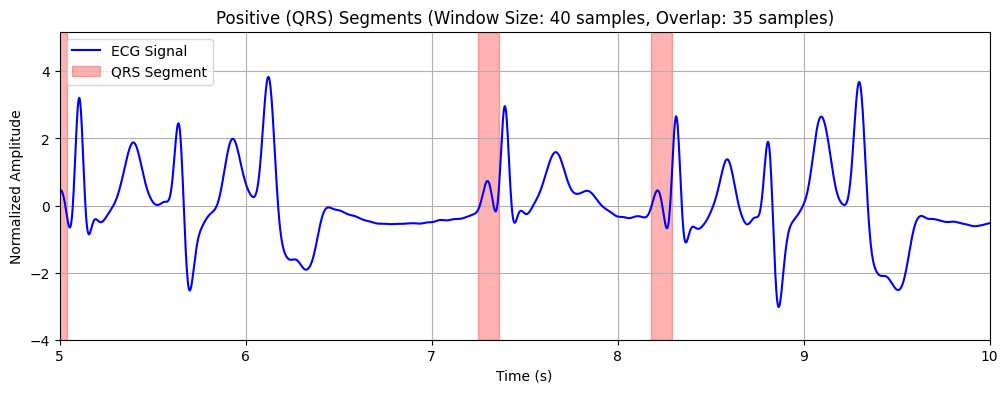

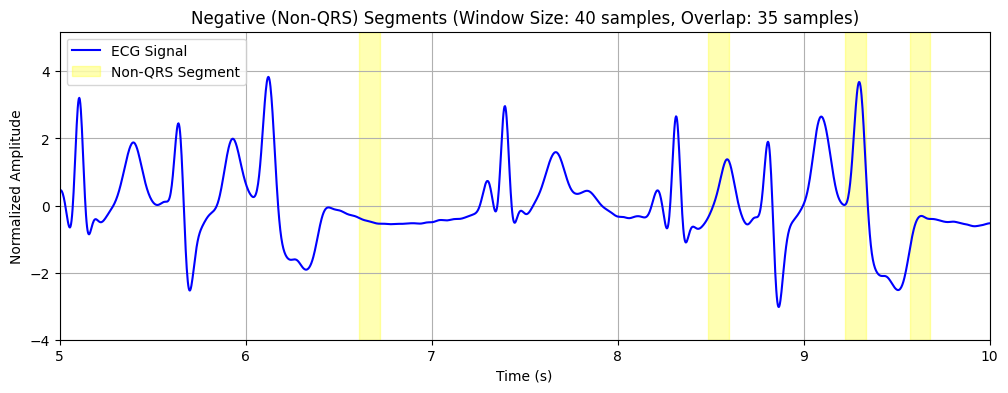

02 positive: 81, negative: 81
Processing record: 03 from but-pdb
Number of positive (QRS) segments: 56
Number of negative (non-QRS) segments: 56


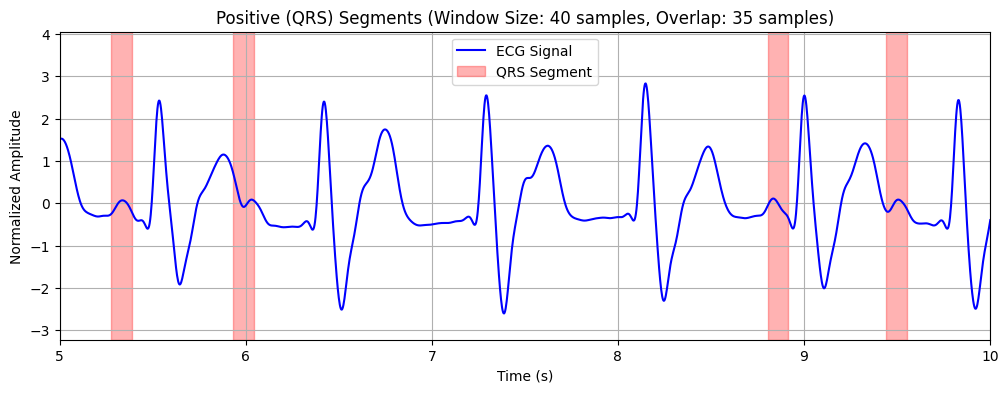

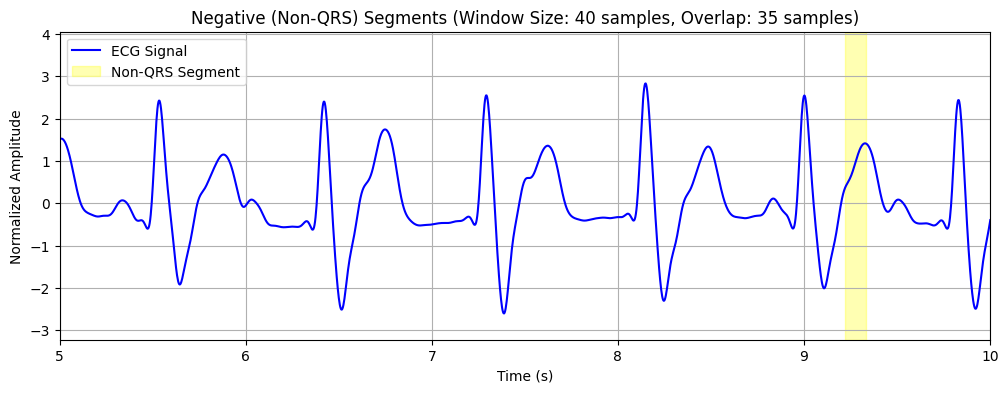

03 positive: 56, negative: 56
Processing record: 04 from but-pdb
Number of positive (QRS) segments: 115
Number of negative (non-QRS) segments: 115


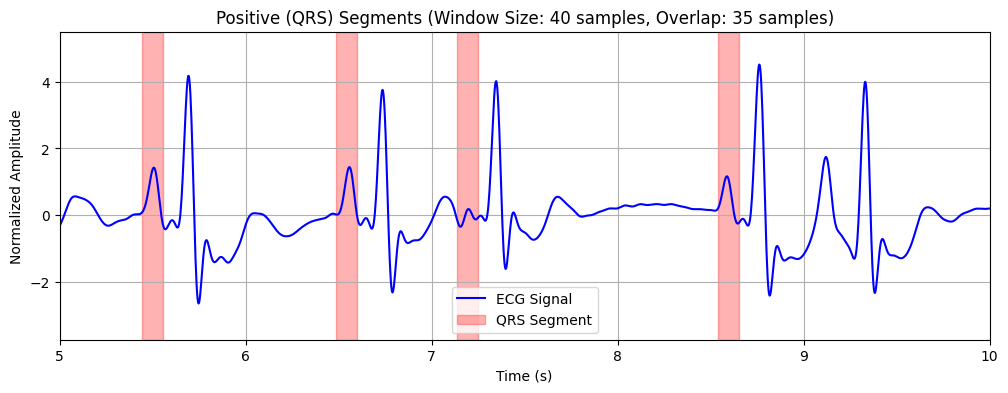

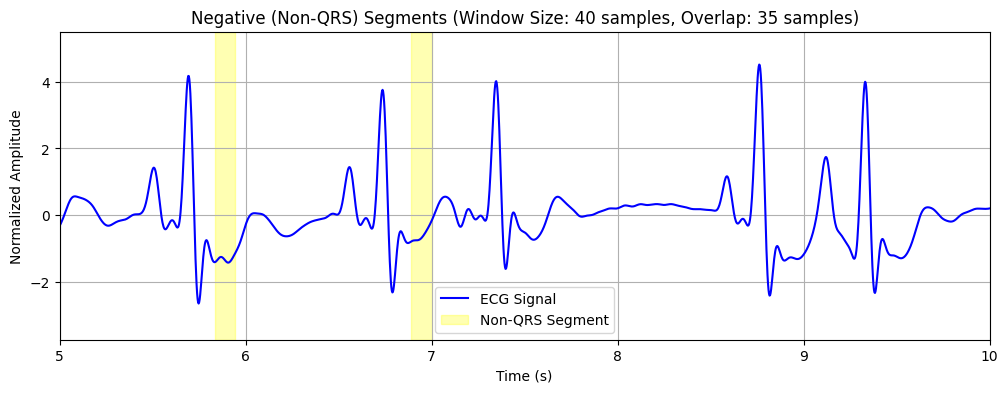

04 positive: 115, negative: 115
Processing record: 05 from but-pdb
Number of positive (QRS) segments: 139
Number of negative (non-QRS) segments: 139


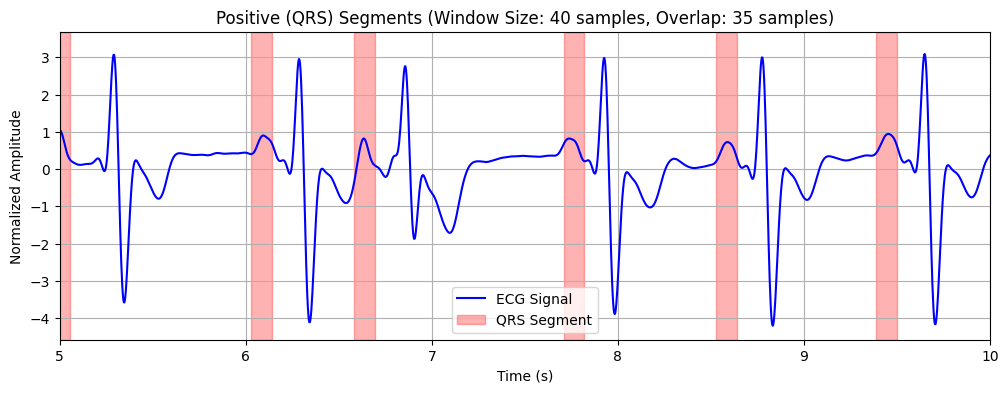

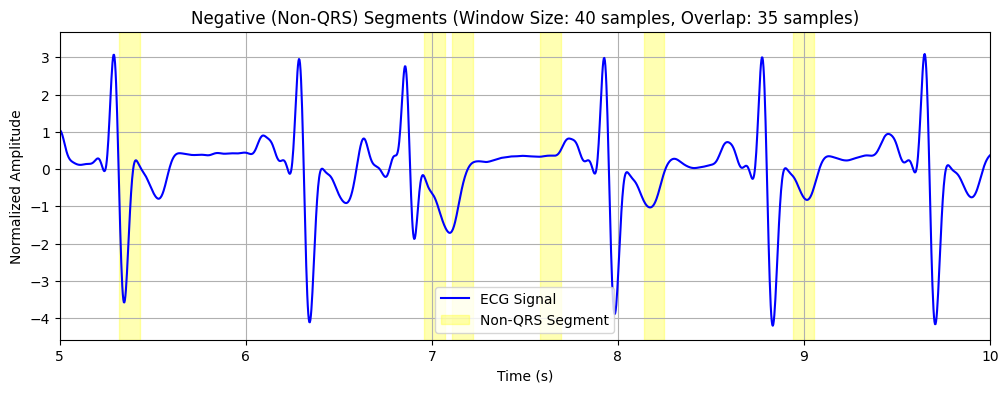

05 positive: 139, negative: 139
Processing record: 06 from but-pdb
Number of positive (QRS) segments: 65
Number of negative (non-QRS) segments: 65


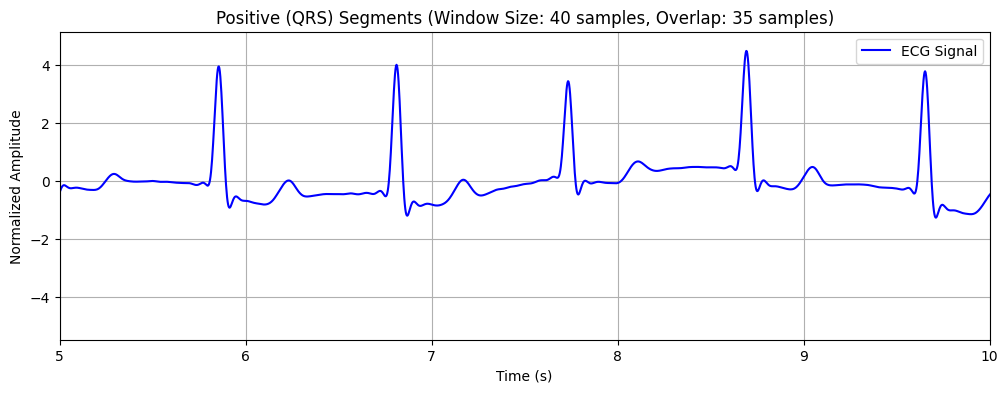

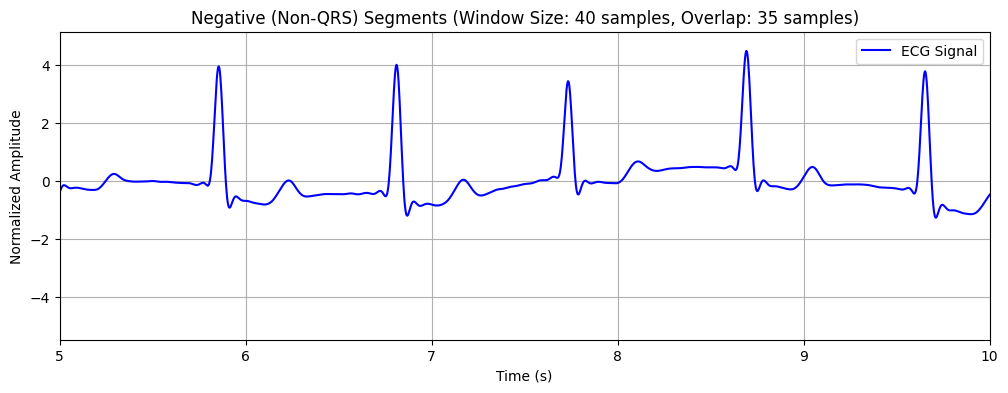

06 positive: 65, negative: 65
Processing record: 07 from but-pdb
Number of positive (QRS) segments: 54
Number of negative (non-QRS) segments: 54


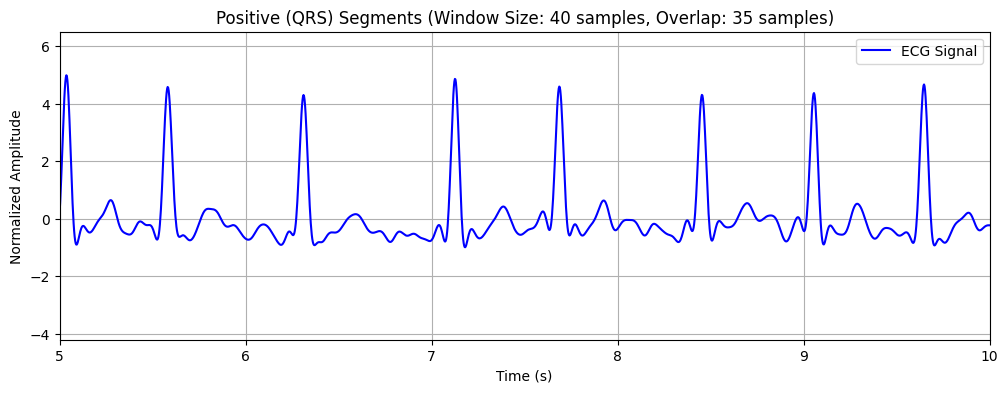

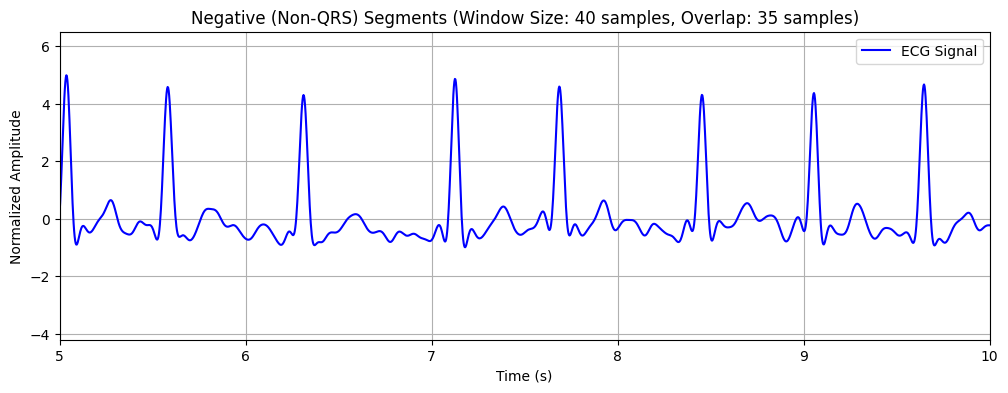

07 positive: 54, negative: 54
Processing record: 08 from but-pdb
Number of positive (QRS) segments: 1
Number of negative (non-QRS) segments: 0


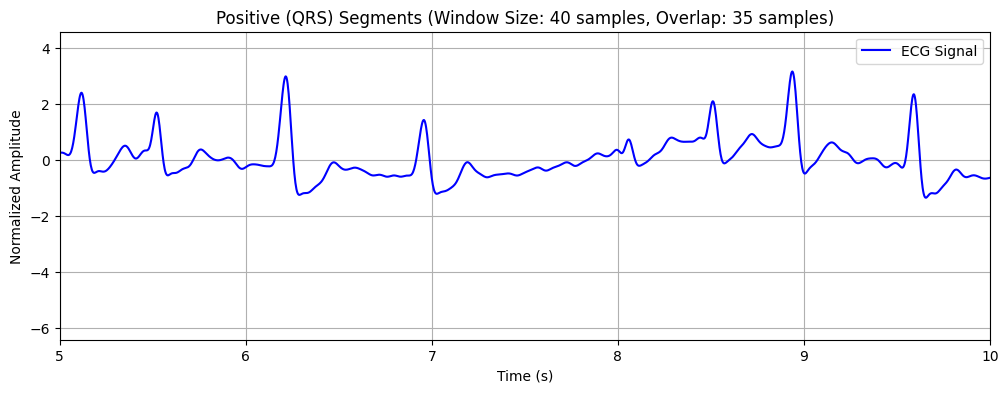

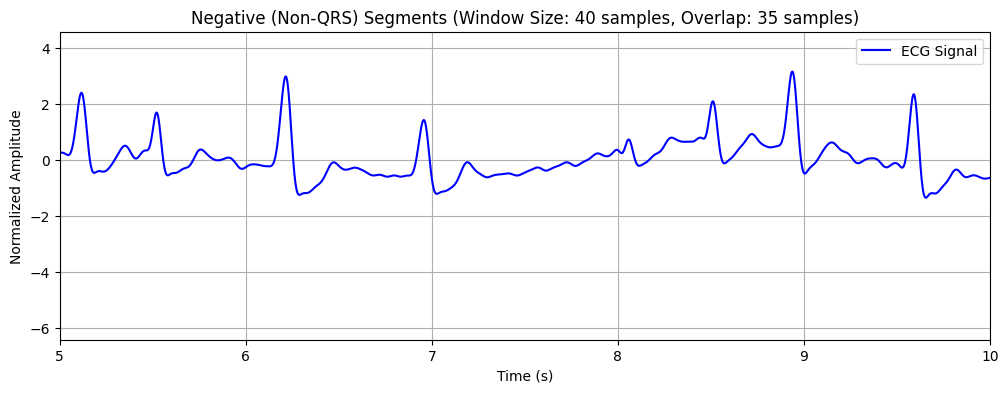

08 positive: 1, negative: 0
Processing record: 09 from but-pdb
Number of positive (QRS) segments: 24
Number of negative (non-QRS) segments: 24


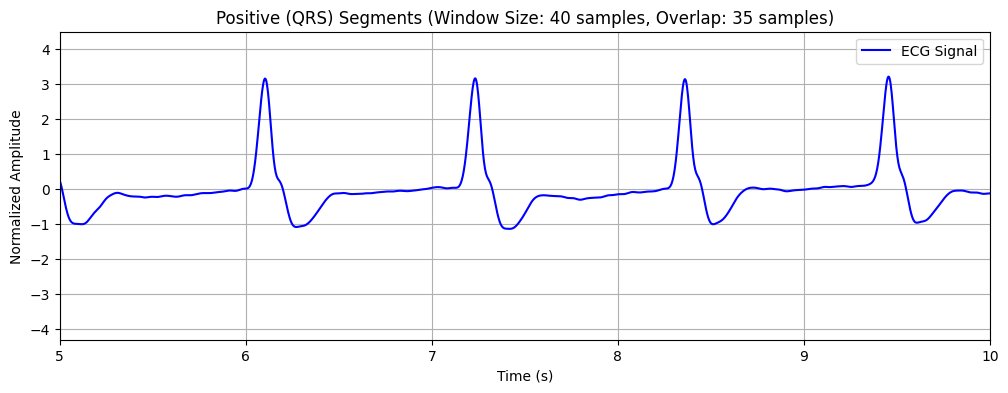

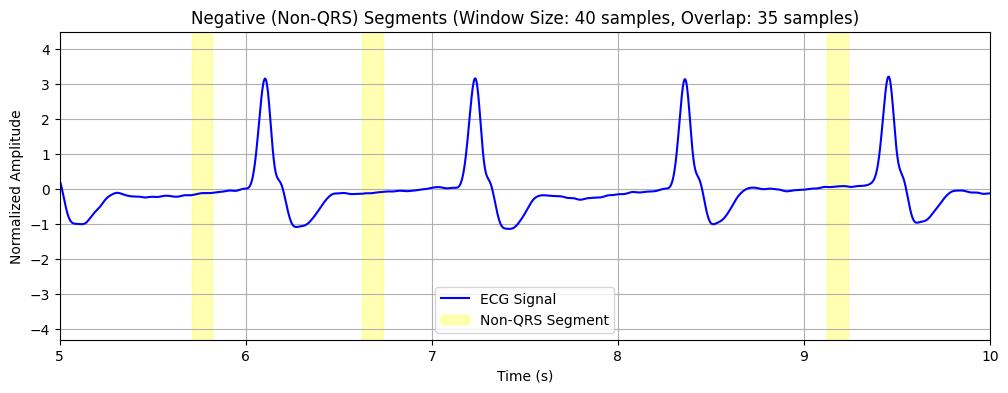

09 positive: 24, negative: 24
Processing record: 10 from but-pdb
Number of positive (QRS) segments: 183
Number of negative (non-QRS) segments: 183


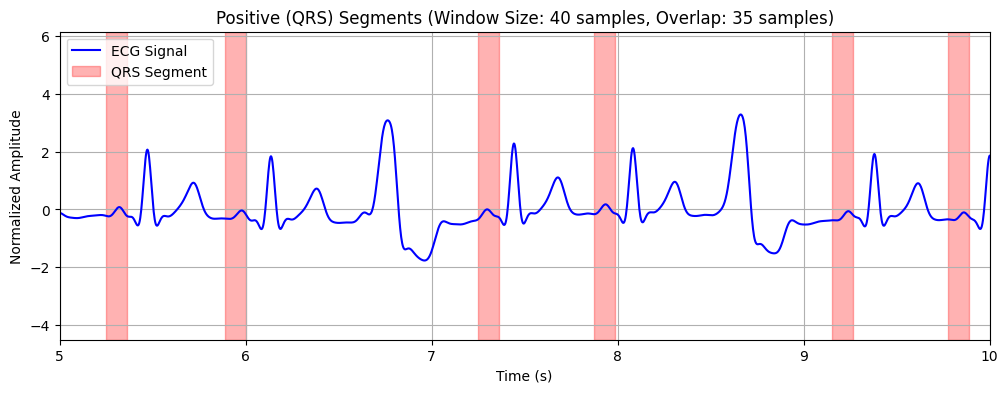

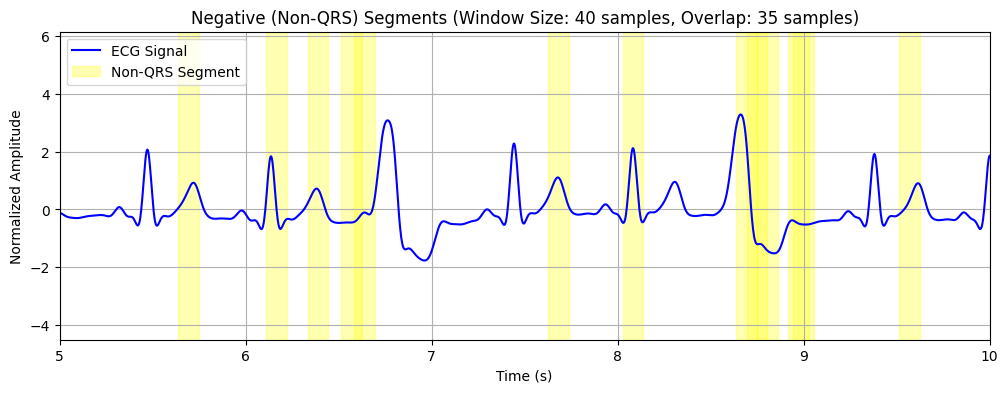

10 positive: 183, negative: 183
Processing record: 11 from but-pdb
Number of positive (QRS) segments: 181
Number of negative (non-QRS) segments: 181


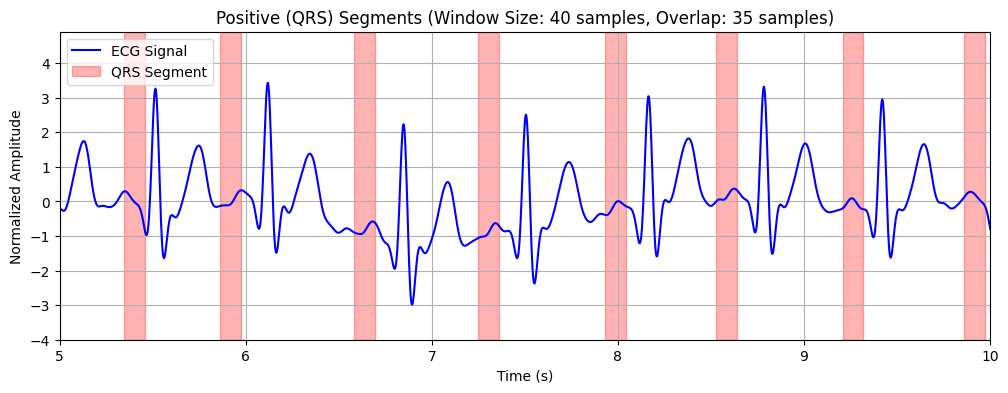

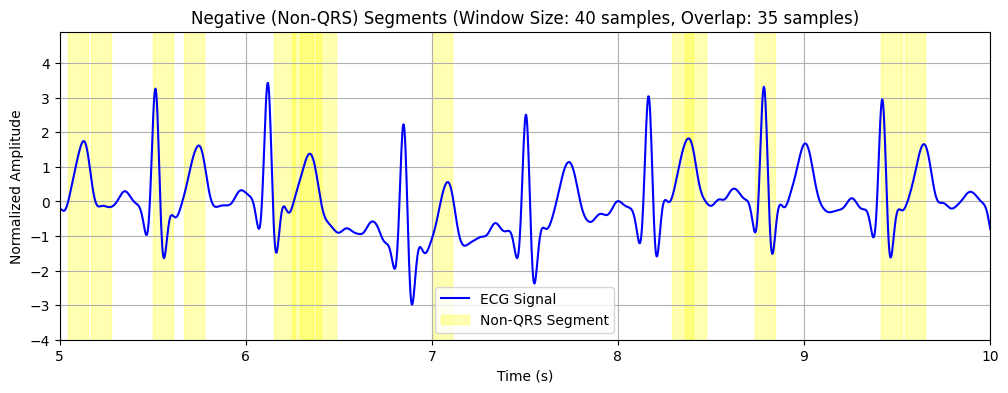

11 positive: 181, negative: 181
Processing record: 12 from but-pdb
Number of positive (QRS) segments: 129
Number of negative (non-QRS) segments: 129


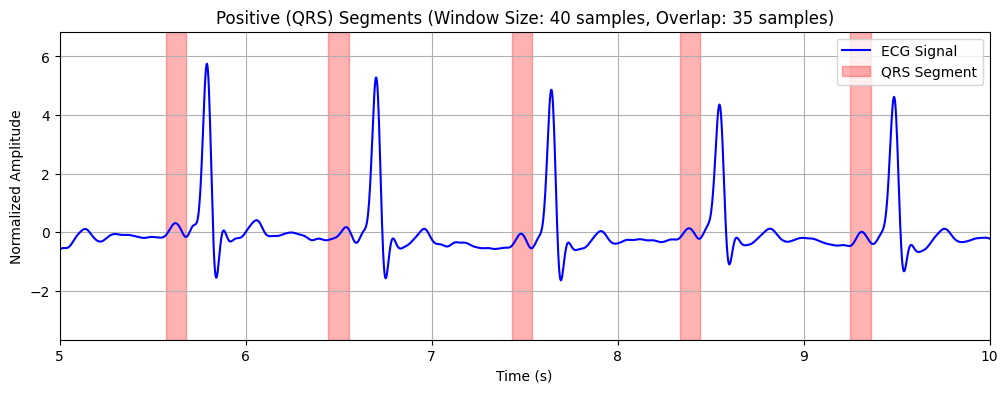

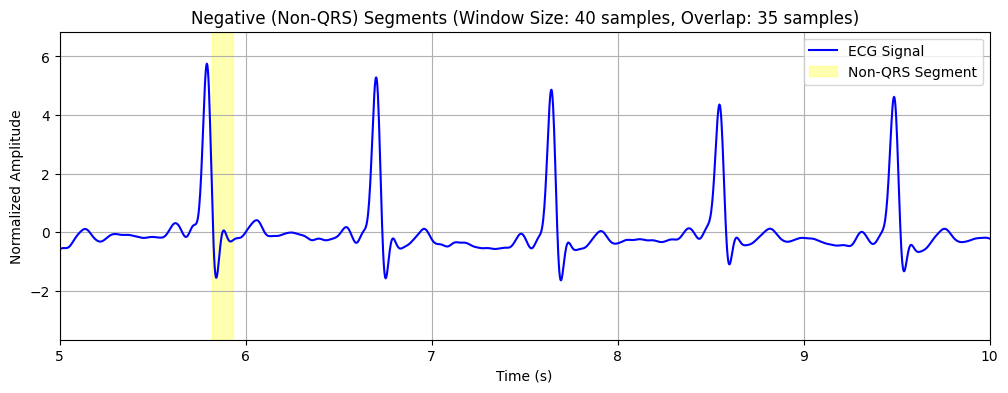

12 positive: 129, negative: 129
Processing record: 13 from but-pdb
Number of positive (QRS) segments: 136
Number of negative (non-QRS) segments: 136


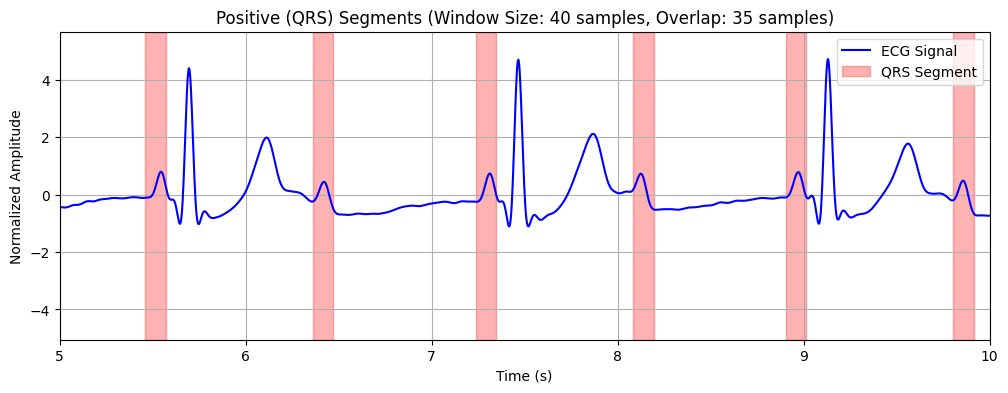

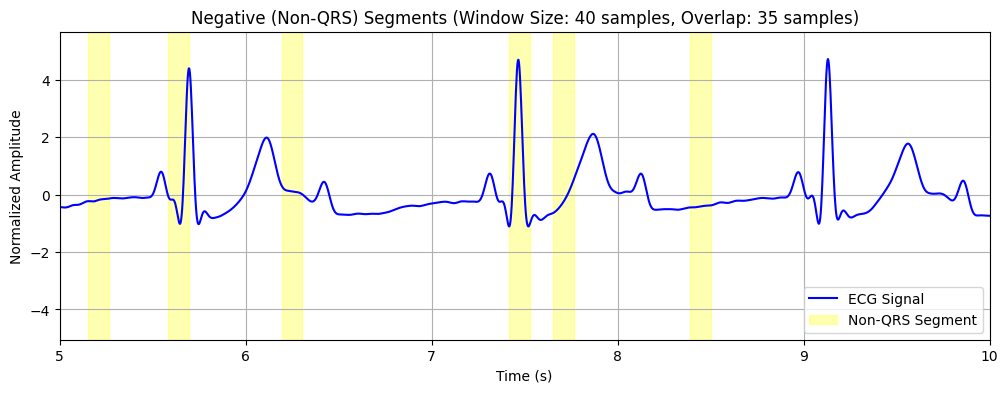

13 positive: 136, negative: 136
Processing record: 14 from but-pdb
Number of positive (QRS) segments: 144
Number of negative (non-QRS) segments: 144


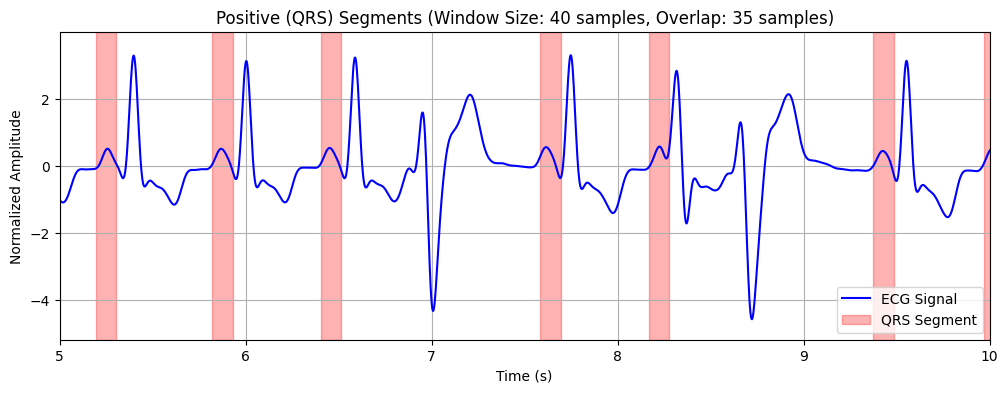

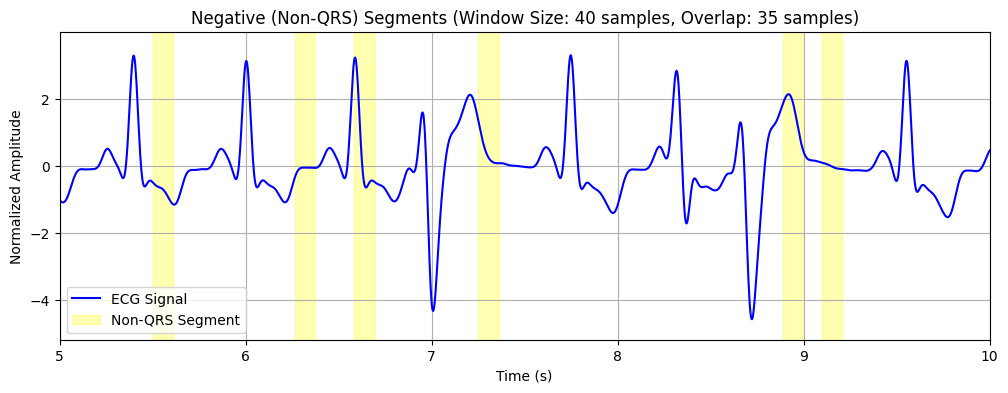

14 positive: 144, negative: 144
Processing record: 15 from but-pdb
Number of positive (QRS) segments: 142
Number of negative (non-QRS) segments: 142


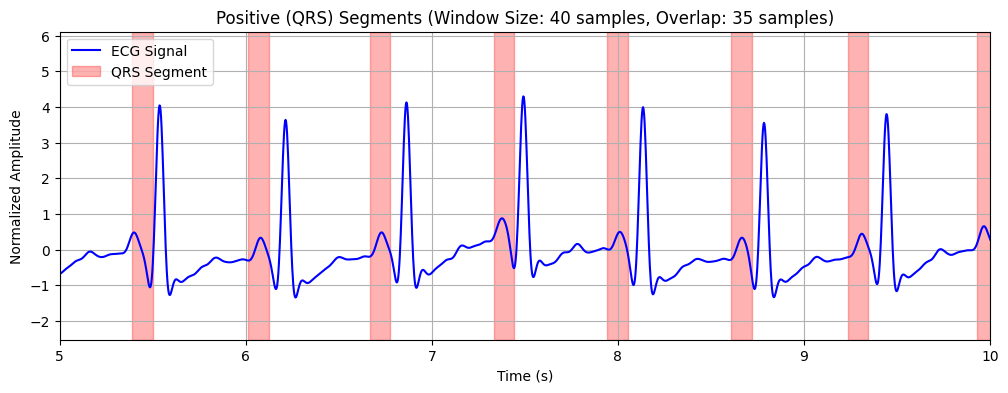

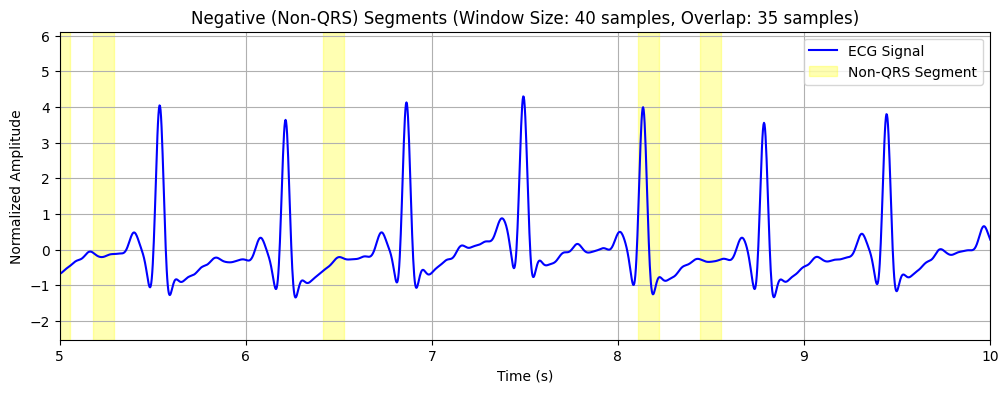

15 positive: 142, negative: 142
Processing record: 16 from but-pdb
Number of positive (QRS) segments: 124
Number of negative (non-QRS) segments: 124


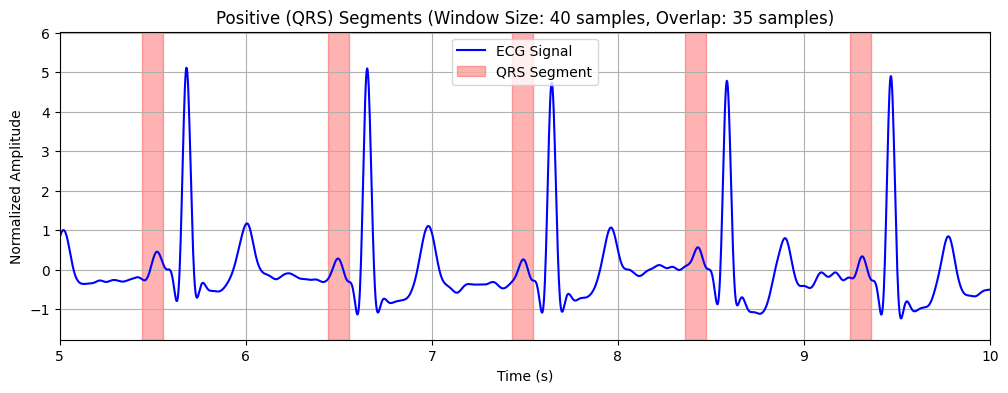

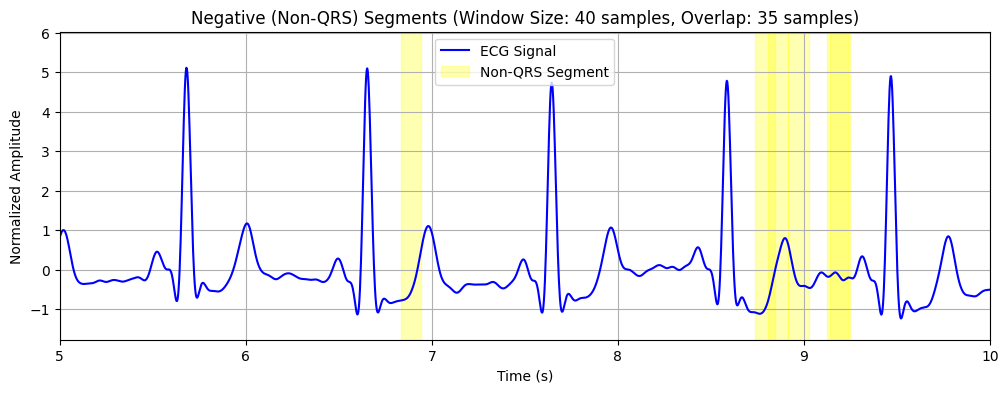

16 positive: 124, negative: 124
Processing record: 17 from but-pdb
Number of positive (QRS) segments: 171
Number of negative (non-QRS) segments: 171


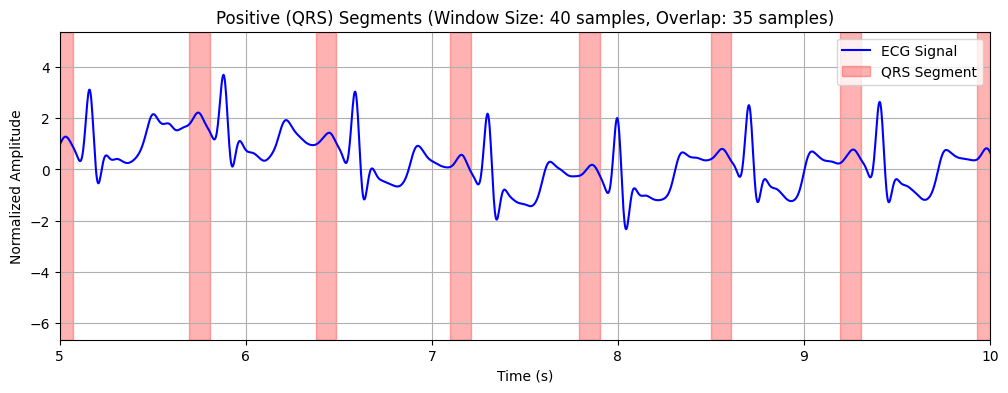

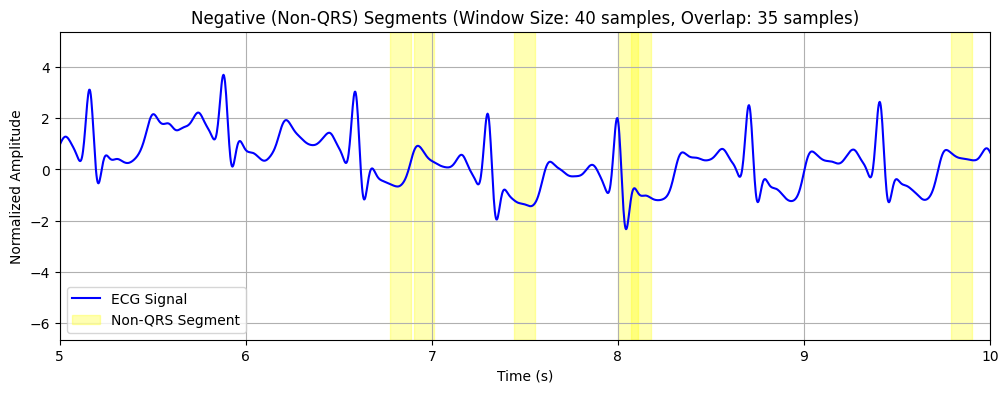

17 positive: 171, negative: 171
Processing record: 18 from but-pdb
Number of positive (QRS) segments: 134
Number of negative (non-QRS) segments: 134


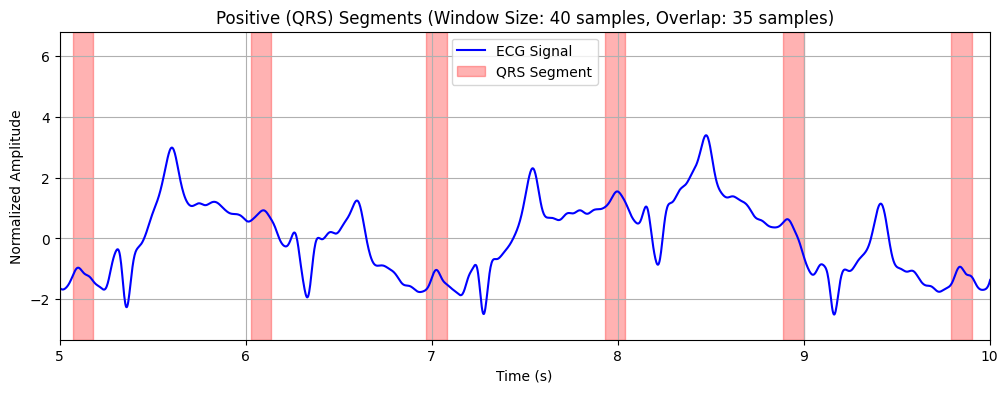

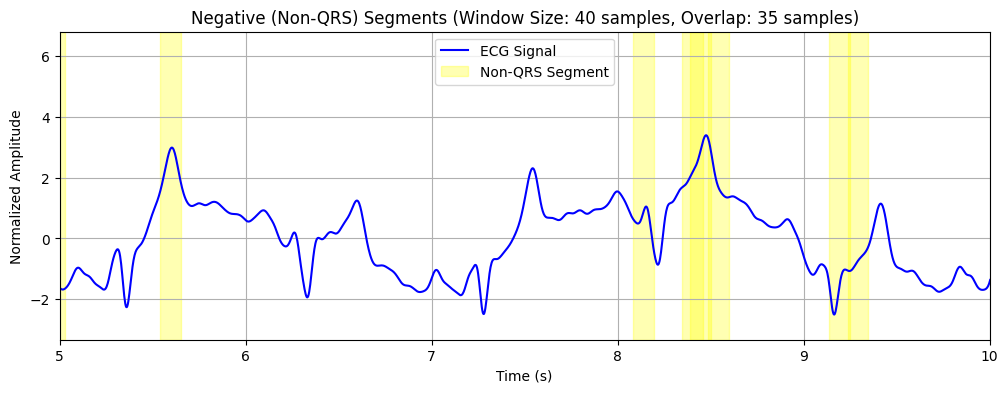

18 positive: 134, negative: 134
Processing record: 19 from but-pdb
Number of positive (QRS) segments: 40
Number of negative (non-QRS) segments: 40


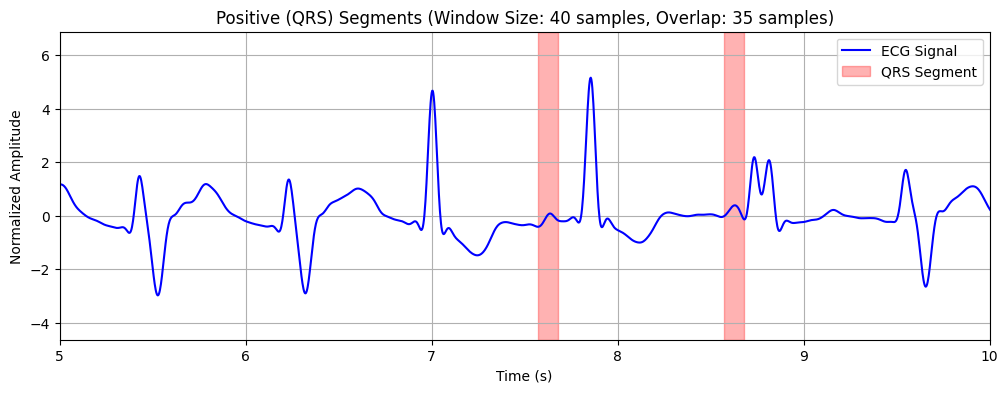

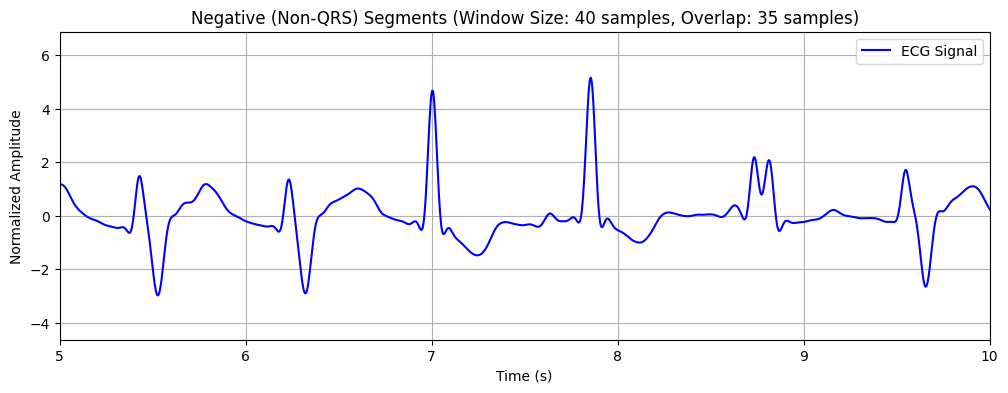

19 positive: 40, negative: 40
Processing record: 20 from but-pdb
Number of positive (QRS) segments: 160
Number of negative (non-QRS) segments: 160


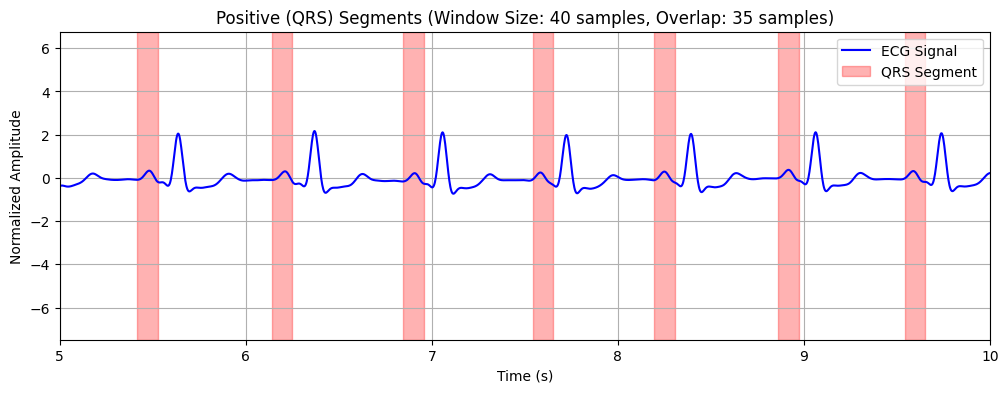

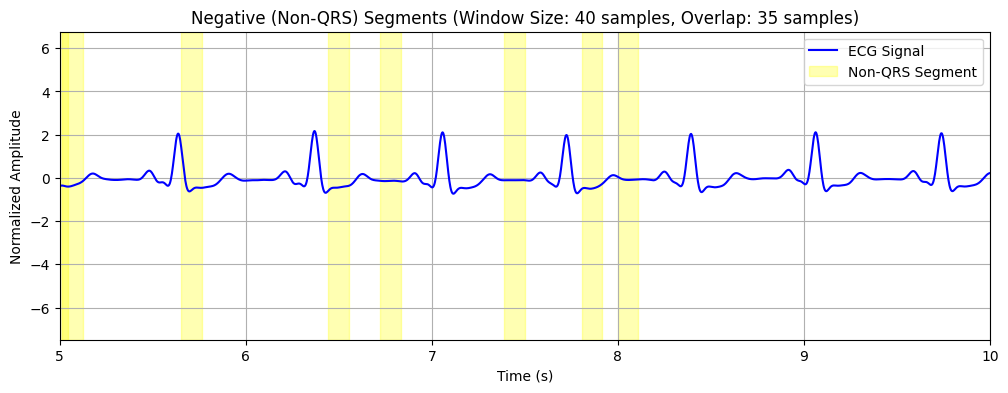

20 positive: 160, negative: 160
Processing record: 21 from but-pdb
Number of positive (QRS) segments: 160
Number of negative (non-QRS) segments: 160


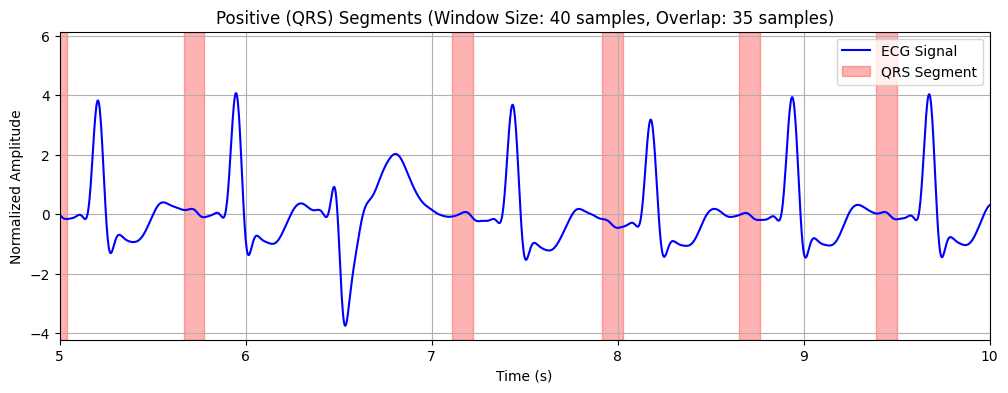

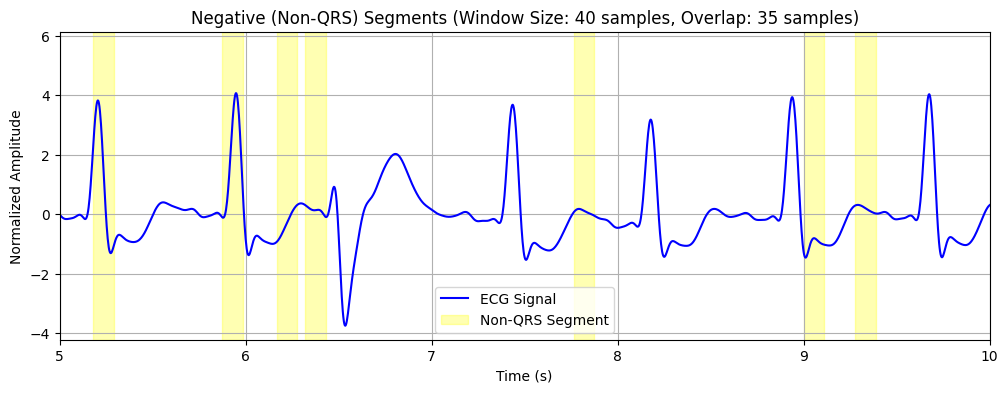

21 positive: 160, negative: 160
Processing record: 22 from but-pdb
Number of positive (QRS) segments: 139
Number of negative (non-QRS) segments: 139


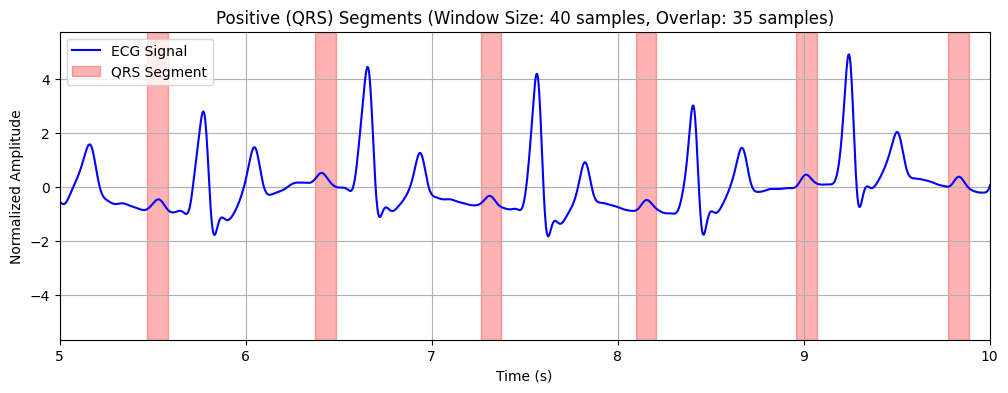

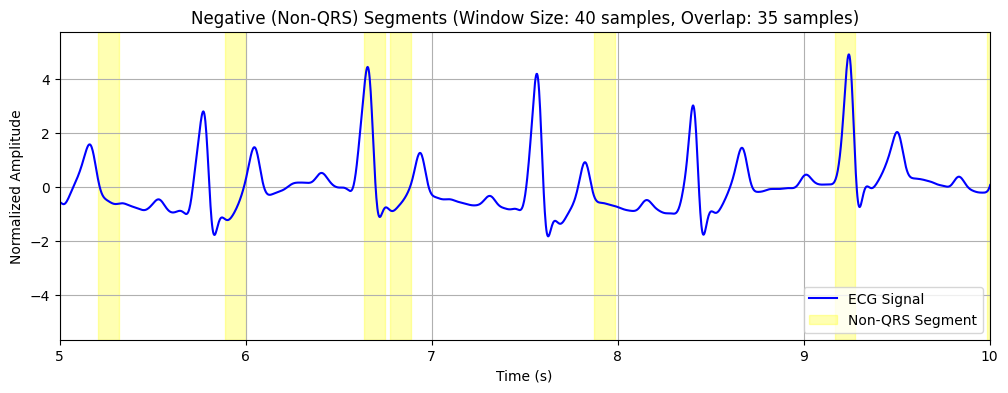

22 positive: 139, negative: 139
Processing record: 23 from but-pdb
Number of positive (QRS) segments: 121
Number of negative (non-QRS) segments: 121


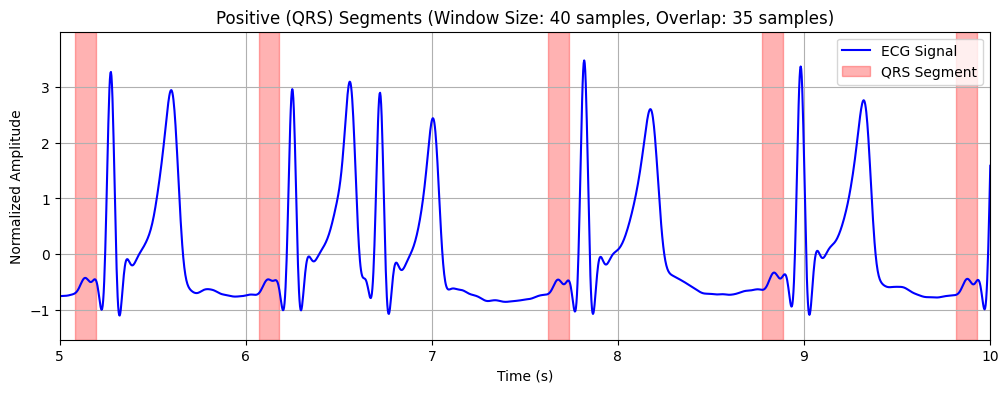

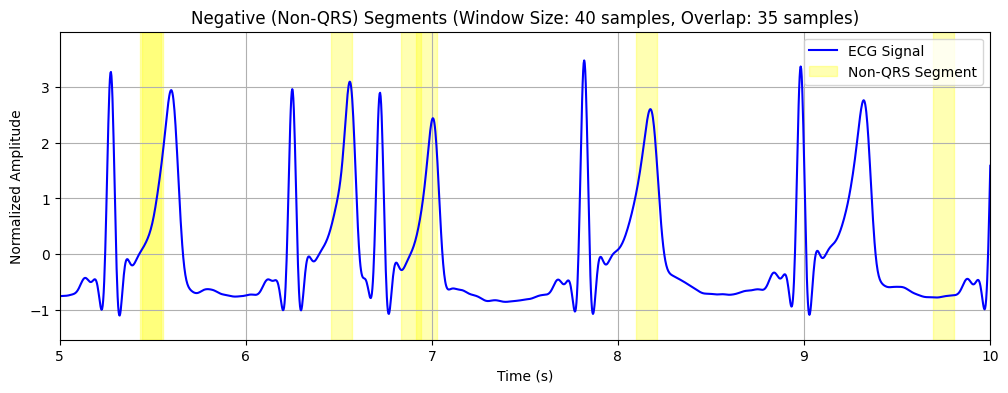

23 positive: 121, negative: 121
Processing record: 24 from but-pdb
Number of positive (QRS) segments: 129
Number of negative (non-QRS) segments: 129


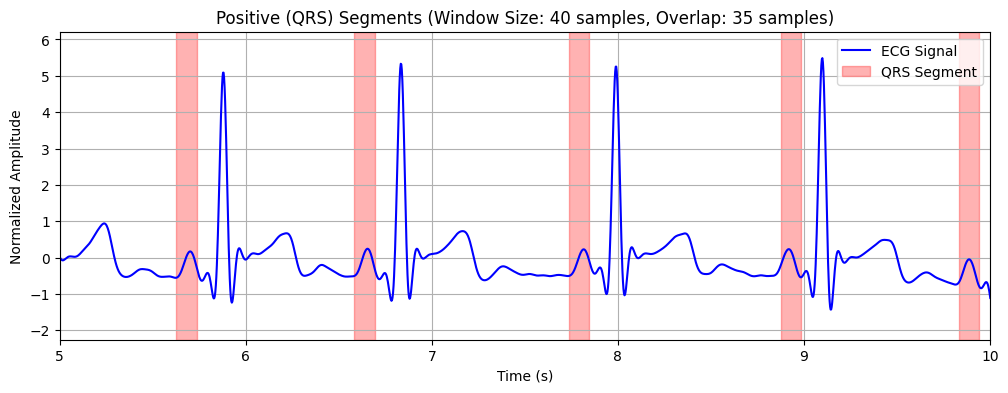

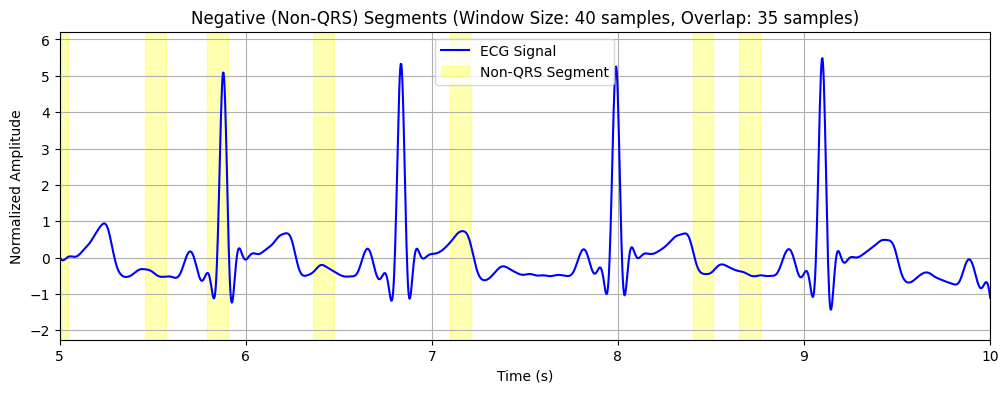

24 positive: 129, negative: 129
Processing record: 25 from but-pdb
Number of positive (QRS) segments: 158
Number of negative (non-QRS) segments: 158


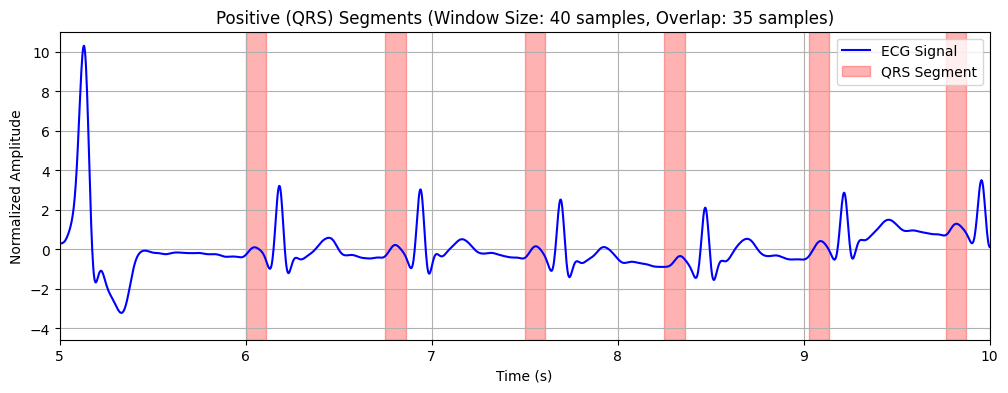

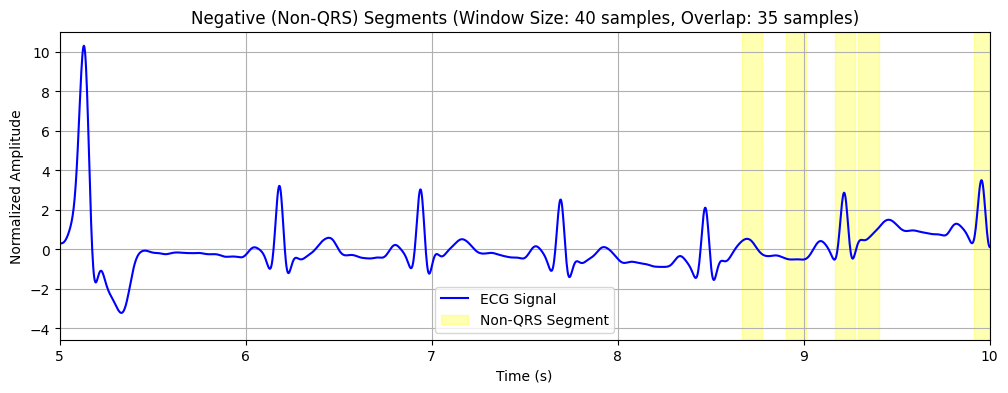

25 positive: 158, negative: 158
Processing record: 26 from but-pdb
Number of positive (QRS) segments: 140
Number of negative (non-QRS) segments: 140


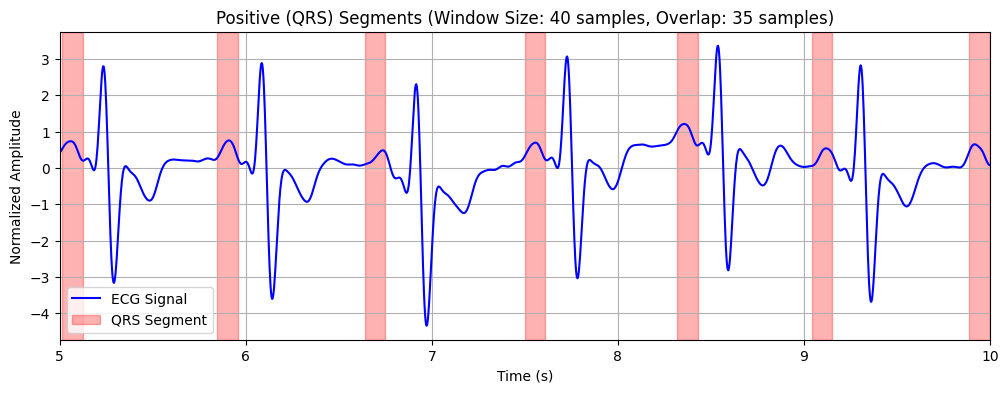

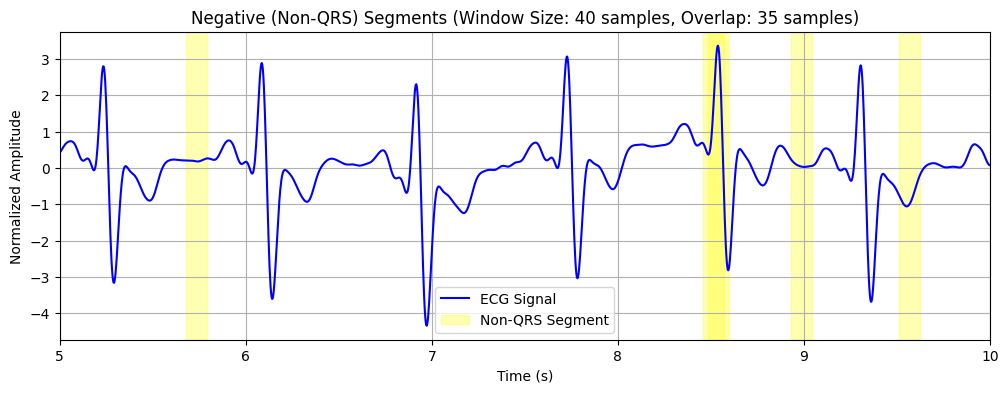

26 positive: 140, negative: 140
Processing record: 27 from but-pdb
Number of positive (QRS) segments: 94
Number of negative (non-QRS) segments: 94


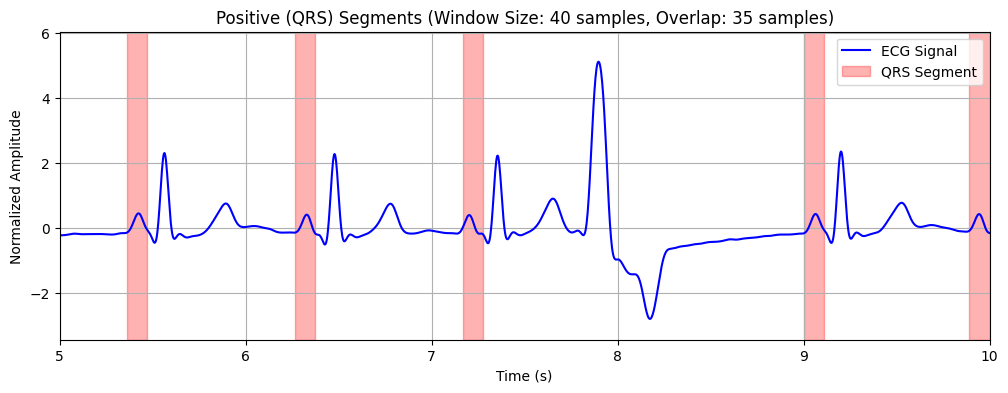

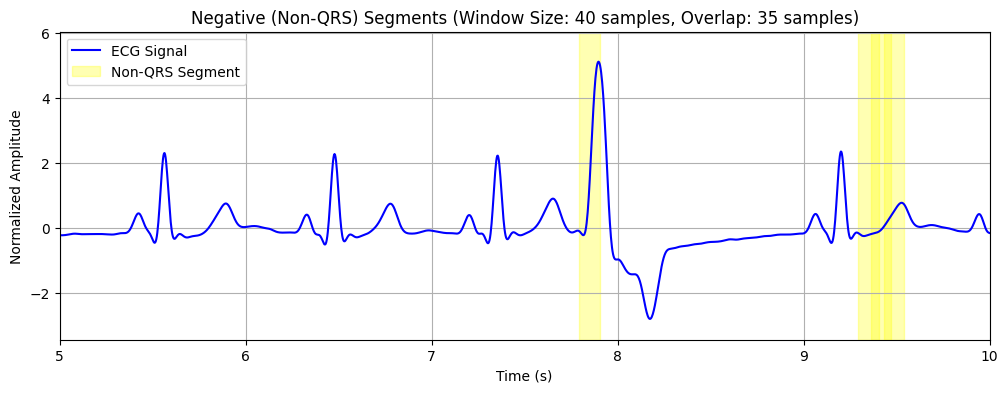

27 positive: 94, negative: 94
Processing record: 28 from but-pdb
Number of positive (QRS) segments: 116
Number of negative (non-QRS) segments: 116


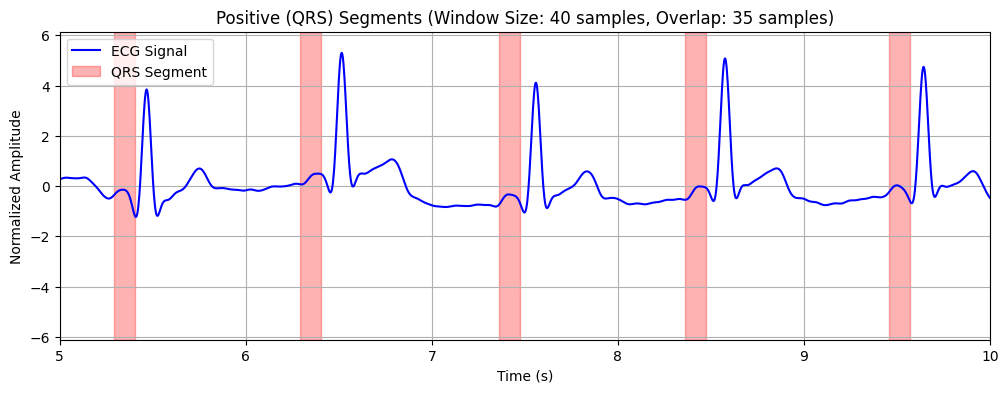

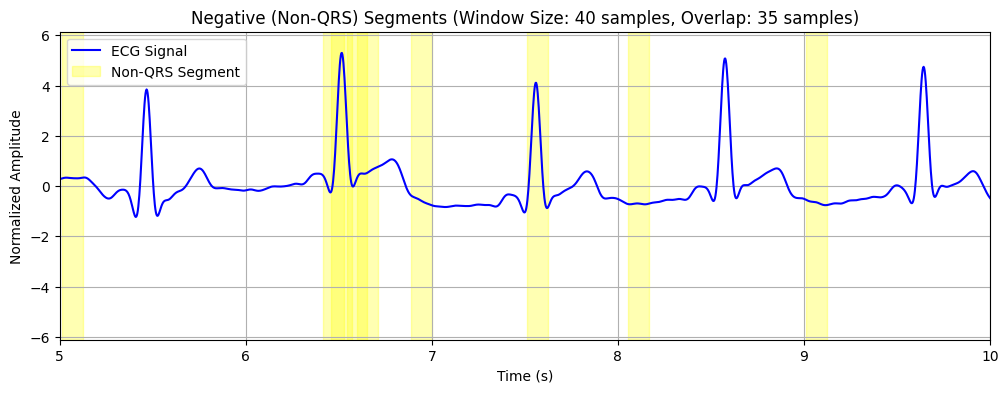

28 positive: 116, negative: 116
Processing record: 29 from but-pdb
Number of positive (QRS) segments: 99
Number of negative (non-QRS) segments: 99


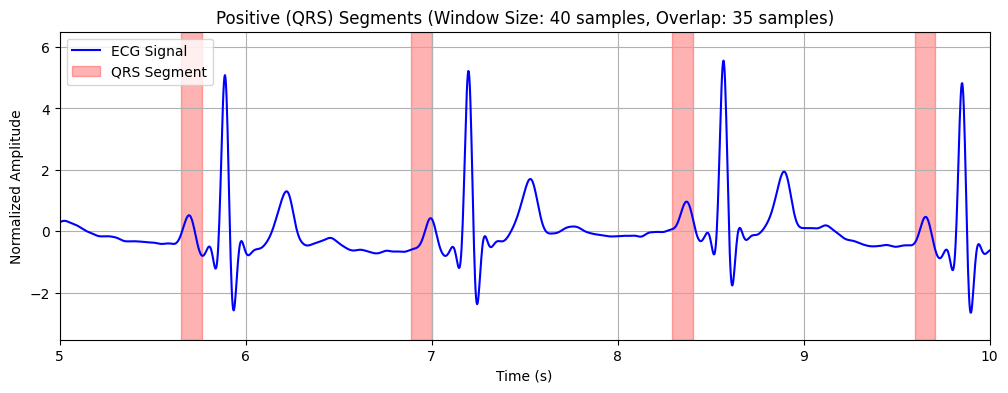

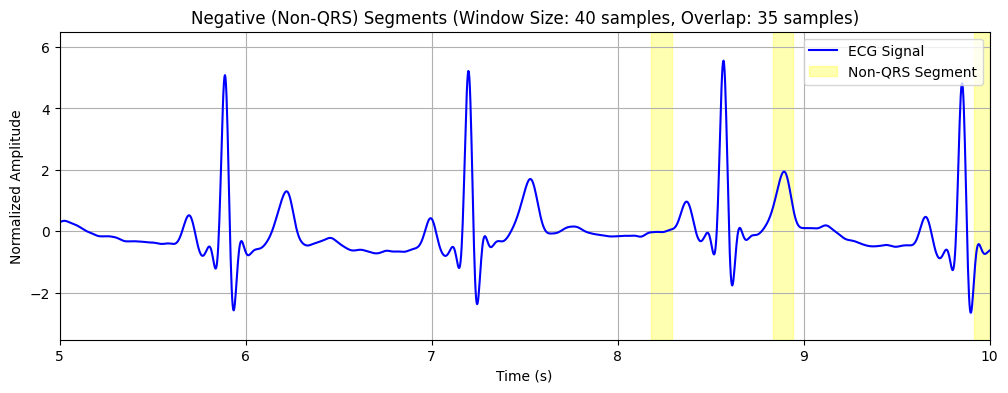

29 positive: 99, negative: 99
Processing record: 30 from but-pdb
Number of positive (QRS) segments: 90
Number of negative (non-QRS) segments: 90


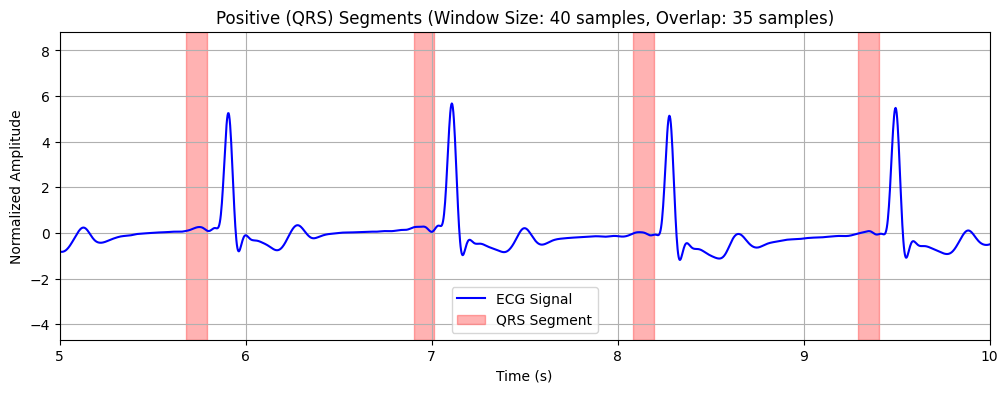

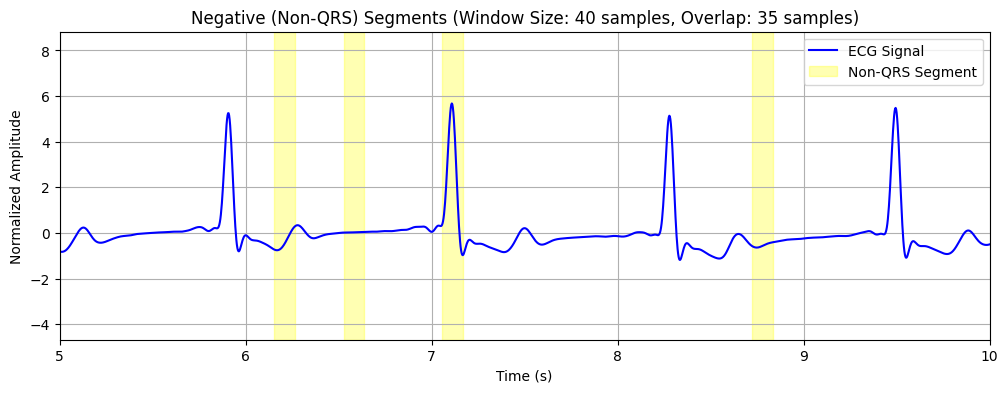

30 positive: 90, negative: 90
Processing record: 31 from but-pdb
Number of positive (QRS) segments: 142
Number of negative (non-QRS) segments: 142


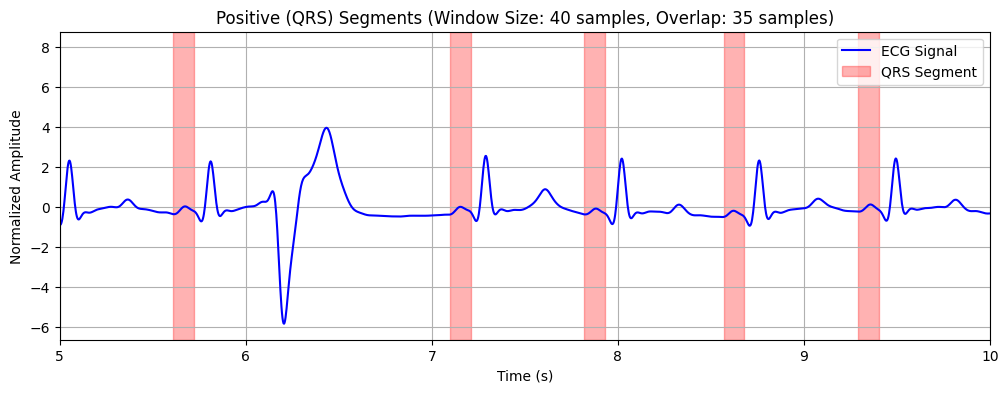

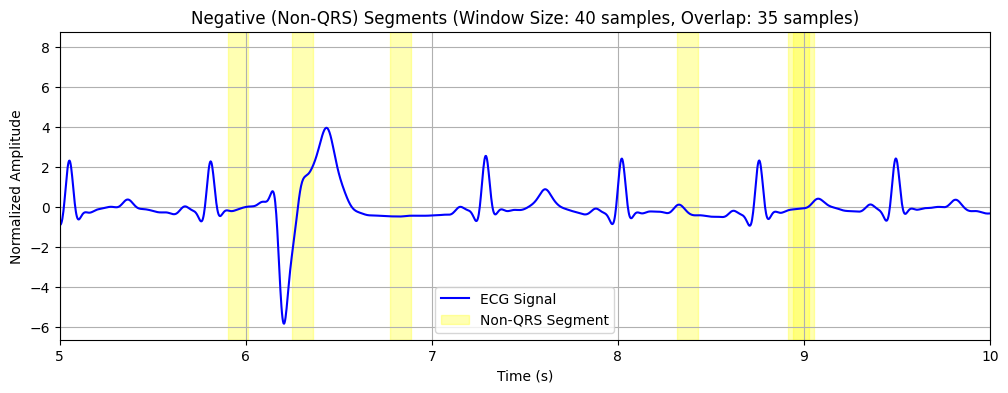

31 positive: 142, negative: 142
Processing record: 32 from but-pdb
Number of positive (QRS) segments: 170
Number of negative (non-QRS) segments: 170


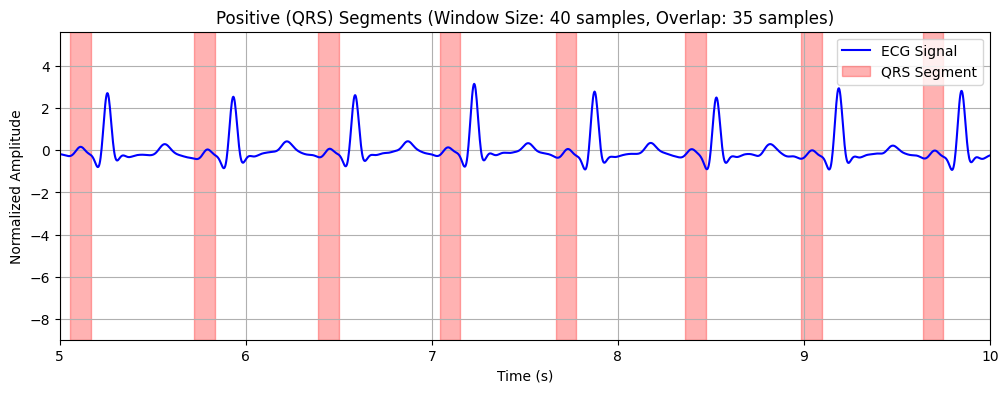

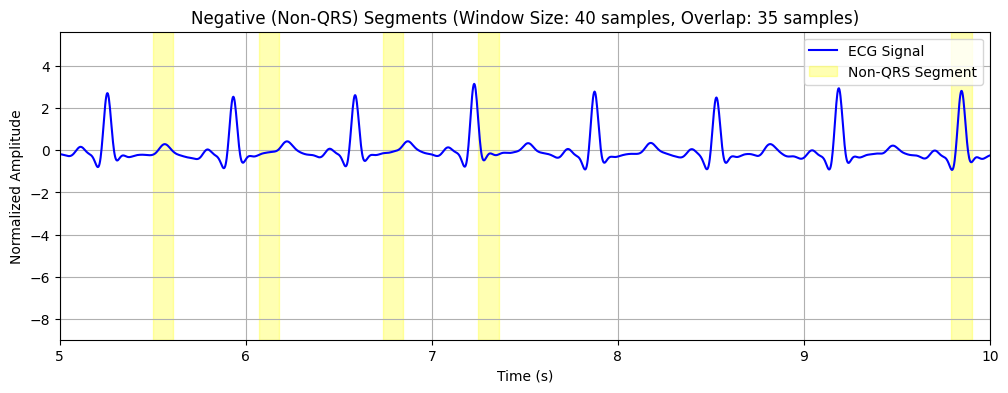

32 positive: 170, negative: 170
Processing record: 33 from but-pdb
Number of positive (QRS) segments: 48
Number of negative (non-QRS) segments: 48


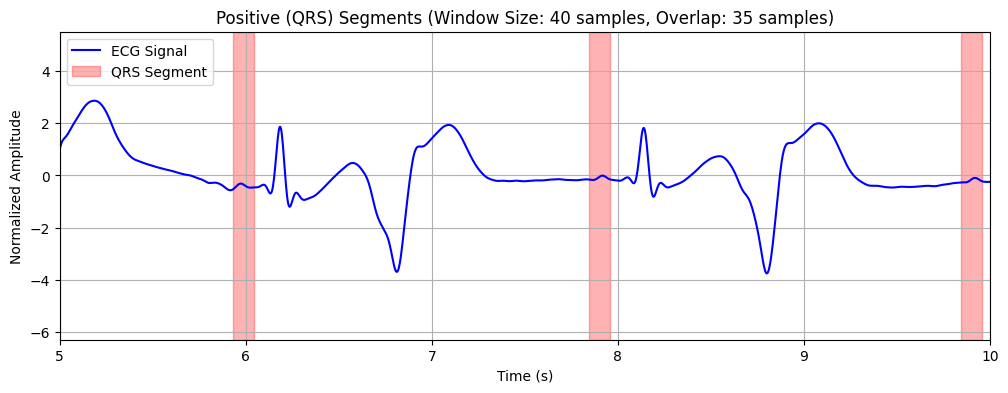

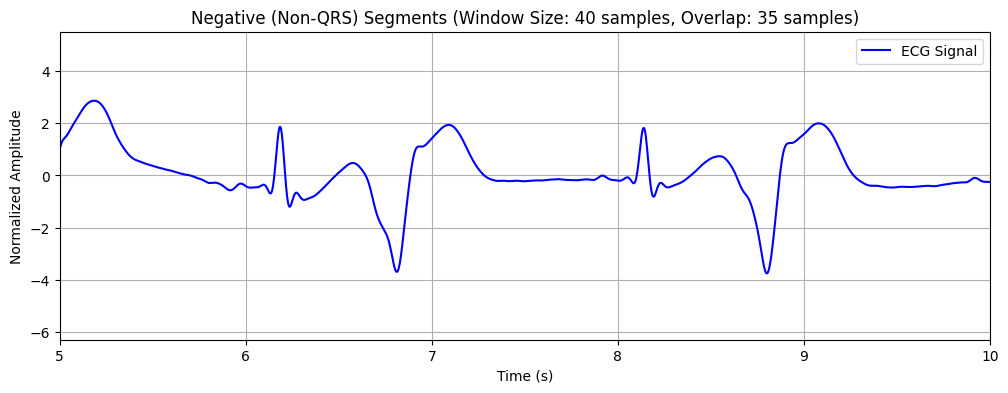

33 positive: 48, negative: 48
Processing record: 34 from but-pdb
Number of positive (QRS) segments: 172
Number of negative (non-QRS) segments: 172


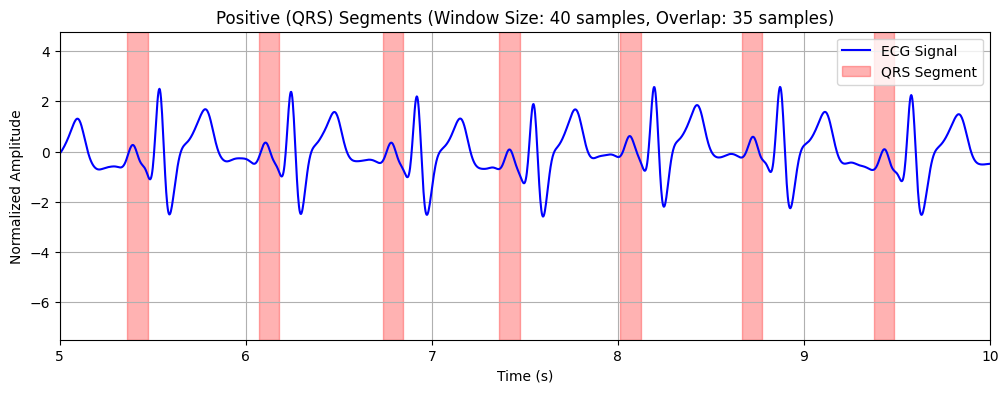

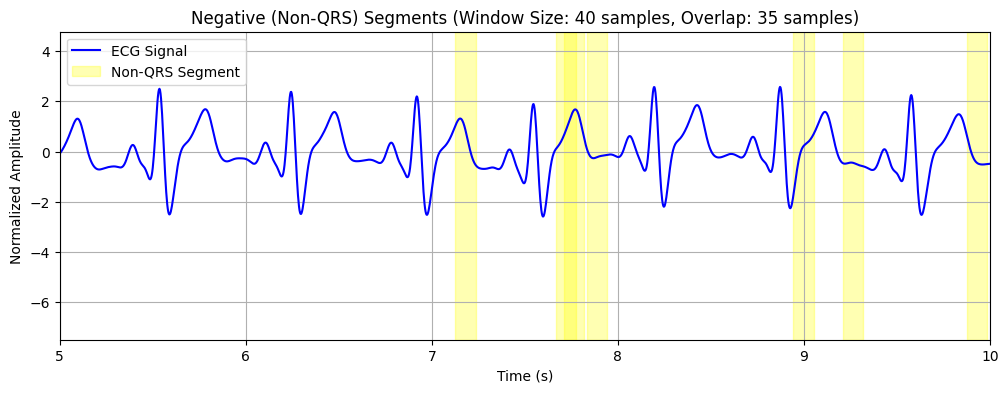

34 positive: 172, negative: 172
Processing record: 35 from but-pdb
Number of positive (QRS) segments: 207
Number of negative (non-QRS) segments: 207


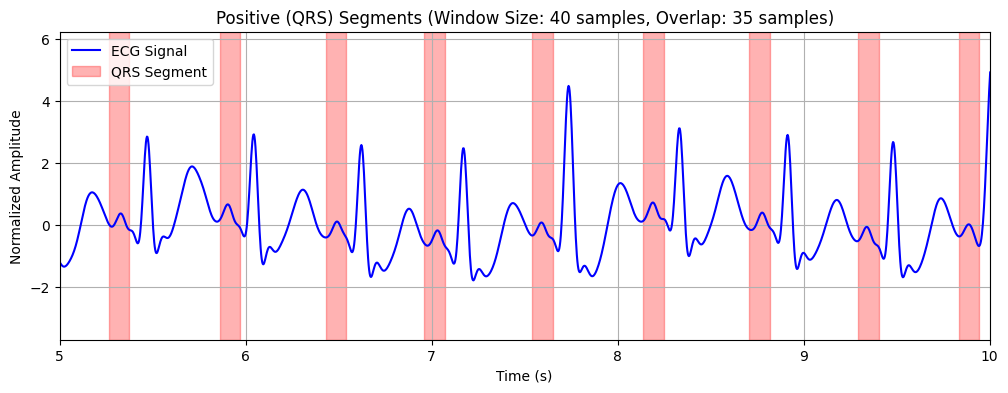

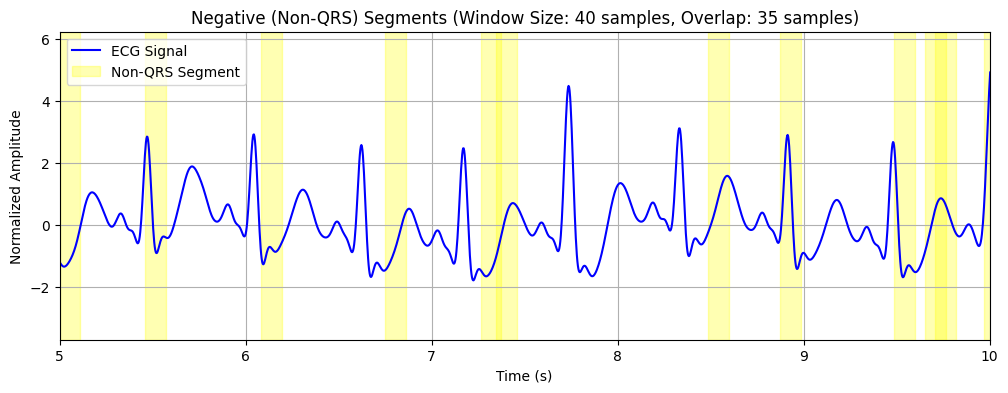

35 positive: 207, negative: 207
Processing record: 36 from but-pdb
Number of positive (QRS) segments: 137
Number of negative (non-QRS) segments: 137


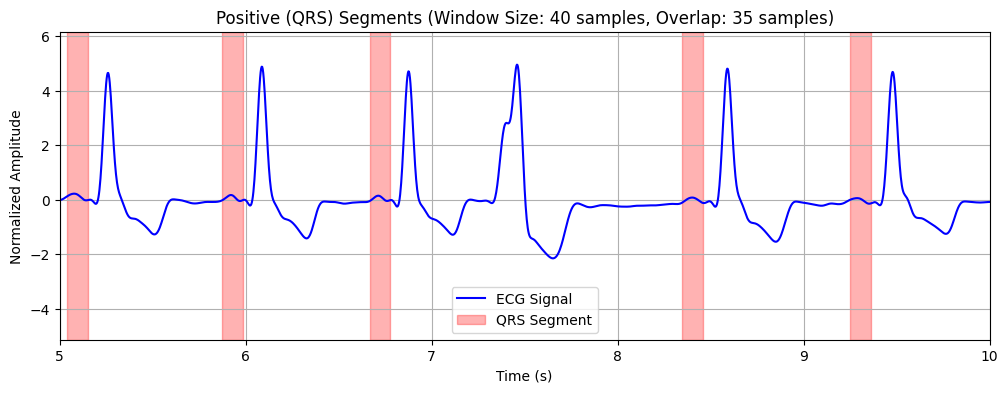

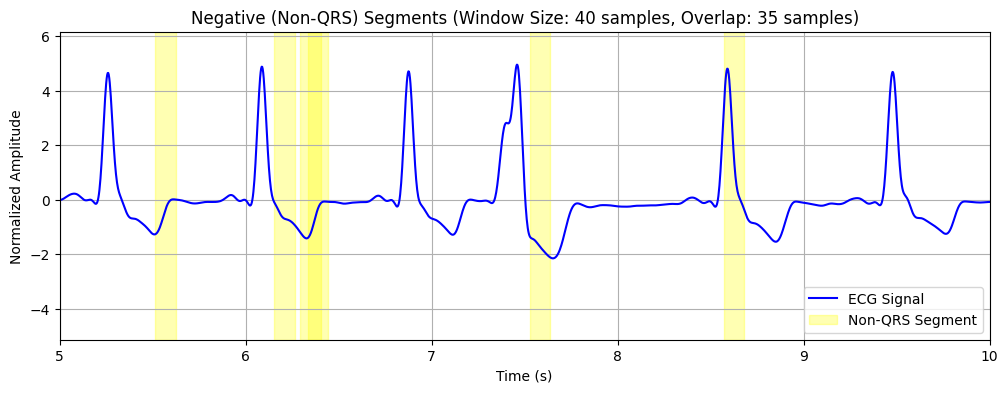

36 positive: 137, negative: 137
Processing record: 37 from but-pdb
Number of positive (QRS) segments: 66
Number of negative (non-QRS) segments: 66


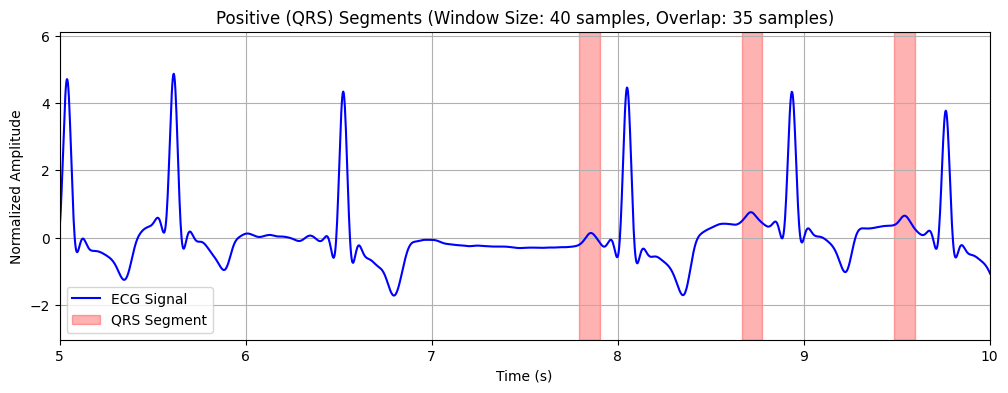

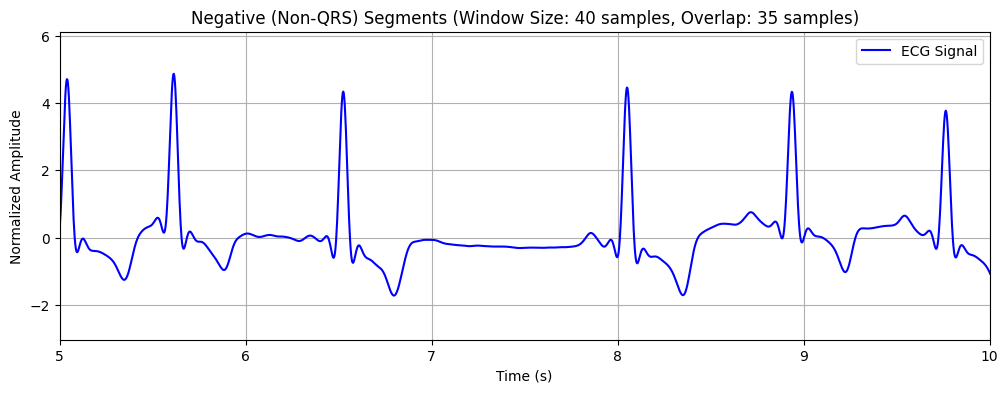

37 positive: 66, negative: 66
Processing record: 38 from but-pdb
Number of positive (QRS) segments: 87
Number of negative (non-QRS) segments: 87


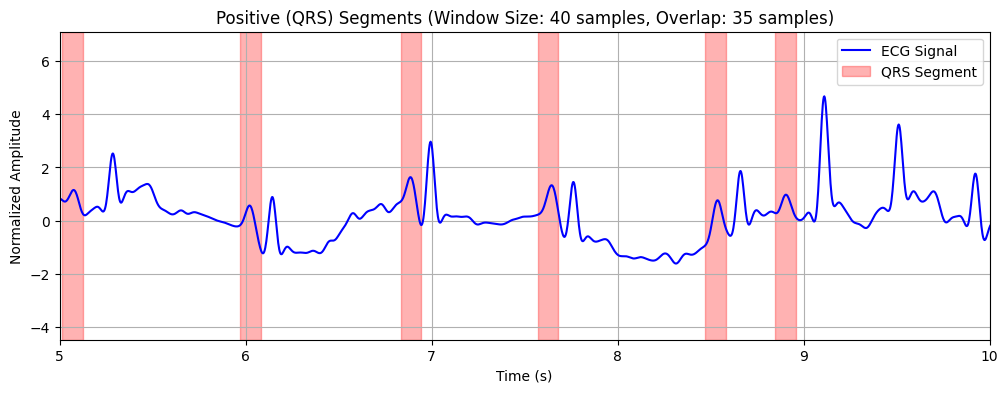

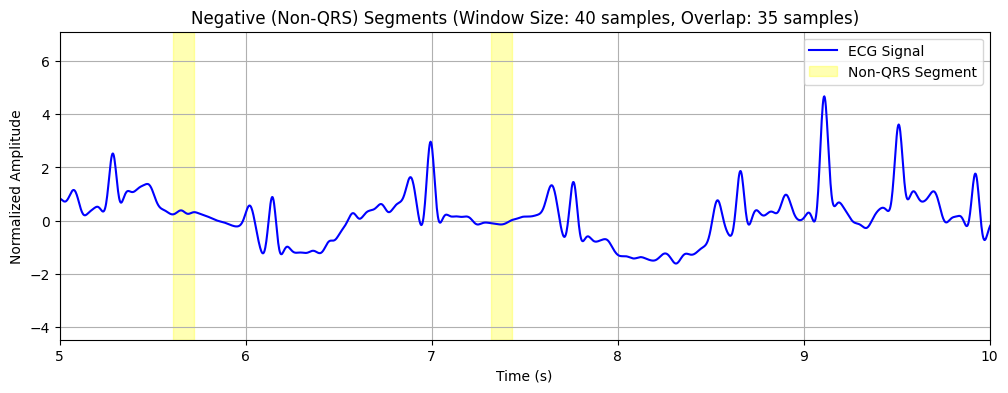

38 positive: 87, negative: 87
Processing record: 39 from but-pdb
Number of positive (QRS) segments: 120
Number of negative (non-QRS) segments: 120


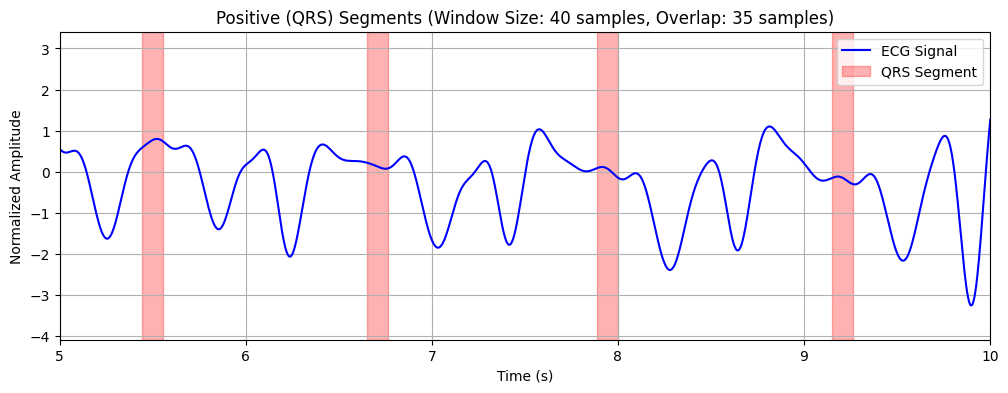

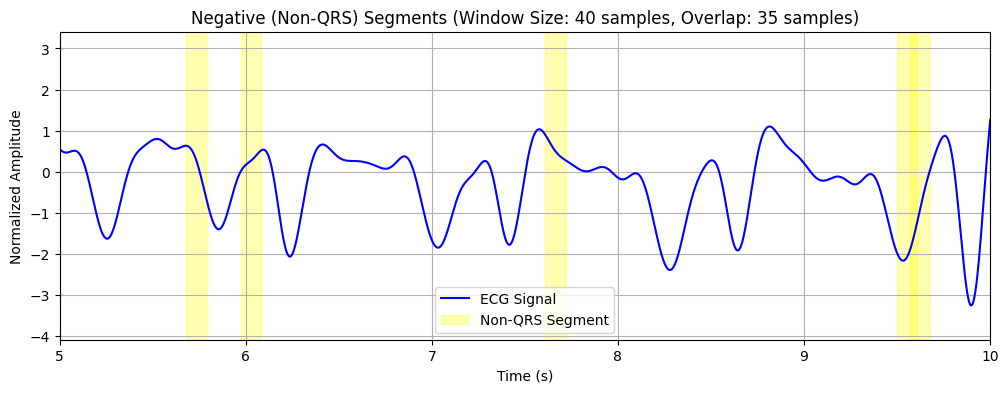

39 positive: 120, negative: 120
Processing record: 40 from but-pdb
Number of positive (QRS) segments: 73
Number of negative (non-QRS) segments: 73


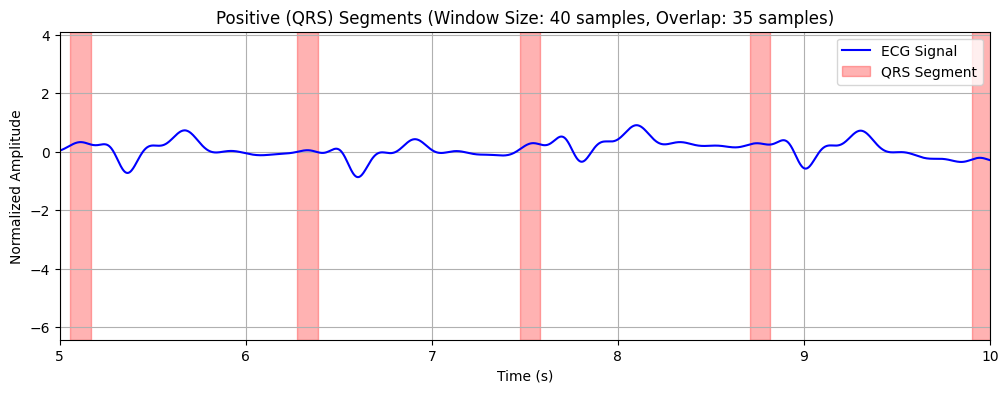

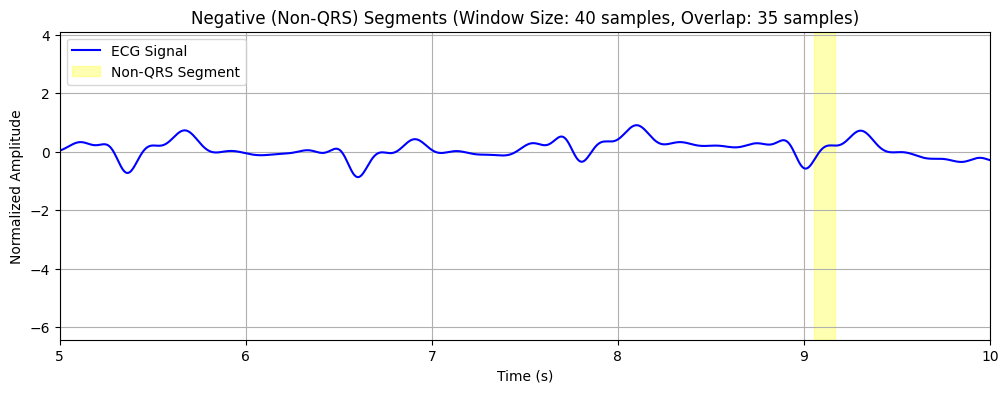

40 positive: 73, negative: 73
Processing record: 41 from but-pdb
Number of positive (QRS) segments: 129
Number of negative (non-QRS) segments: 129


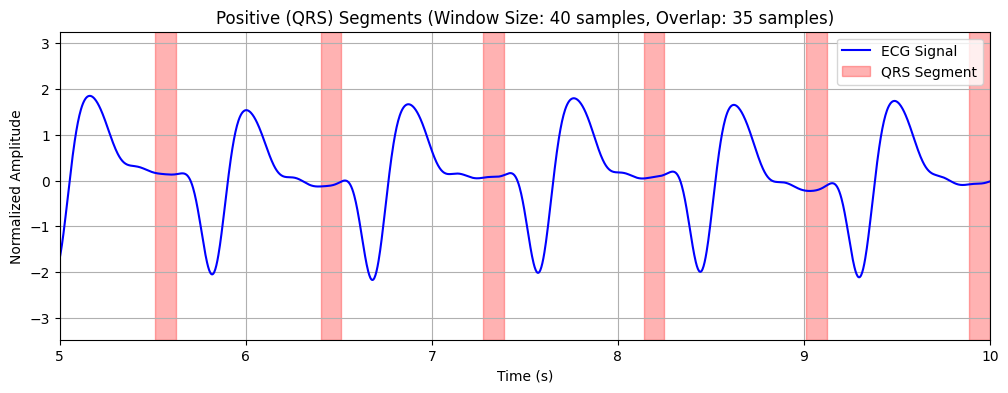

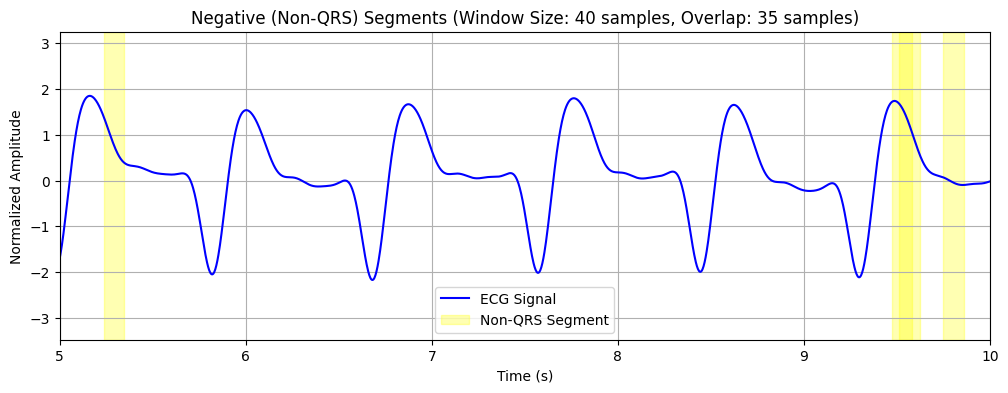

41 positive: 129, negative: 129
Processing record: 42 from but-pdb
Number of positive (QRS) segments: 113
Number of negative (non-QRS) segments: 113


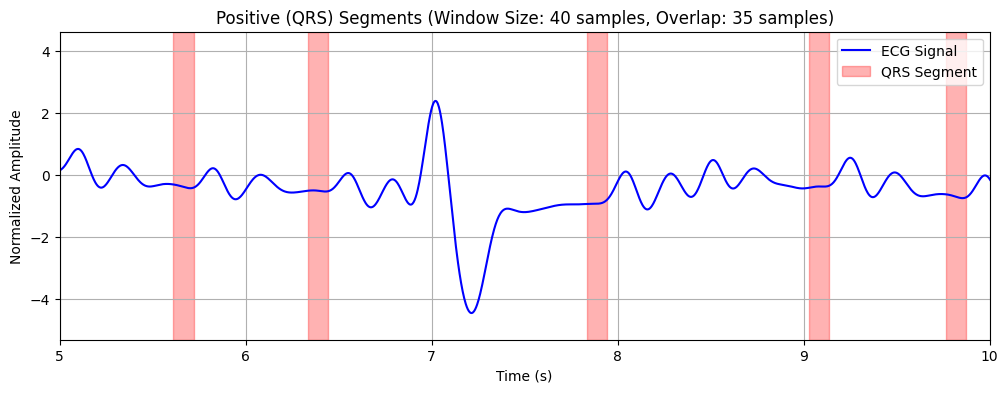

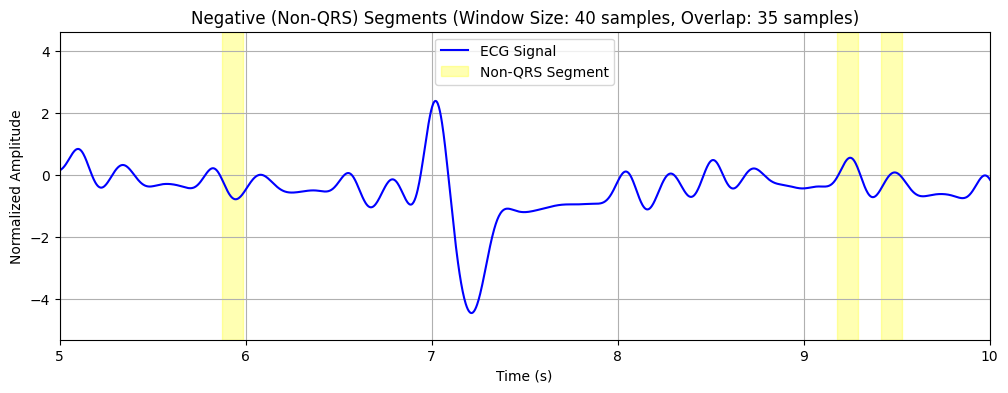

42 positive: 113, negative: 113
Processing record: 43 from but-pdb
Number of positive (QRS) segments: 105
Number of negative (non-QRS) segments: 105


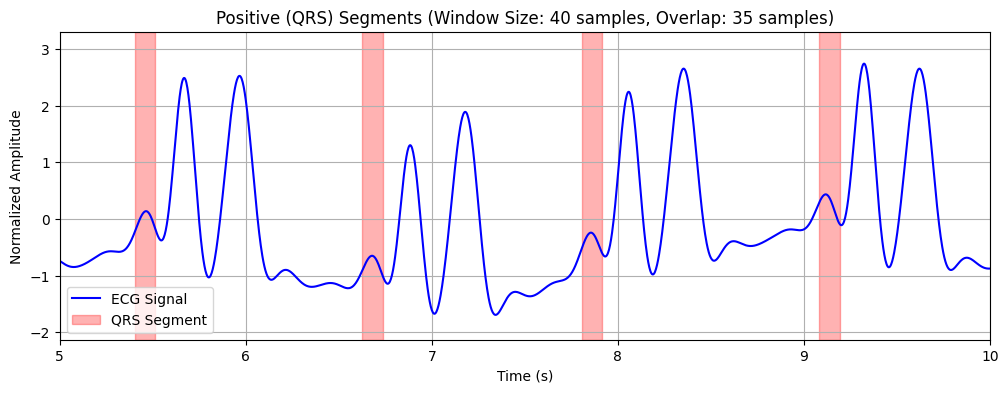

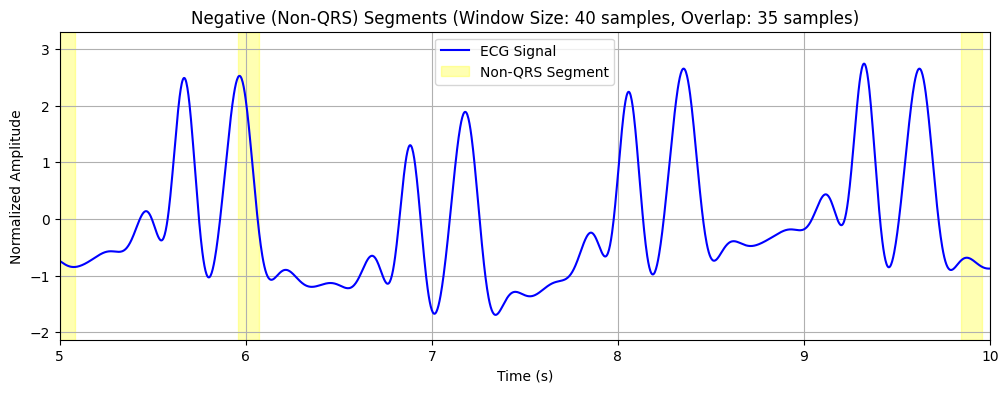

43 positive: 105, negative: 105
Processing record: 44 from but-pdb
Number of positive (QRS) segments: 77
Number of negative (non-QRS) segments: 77


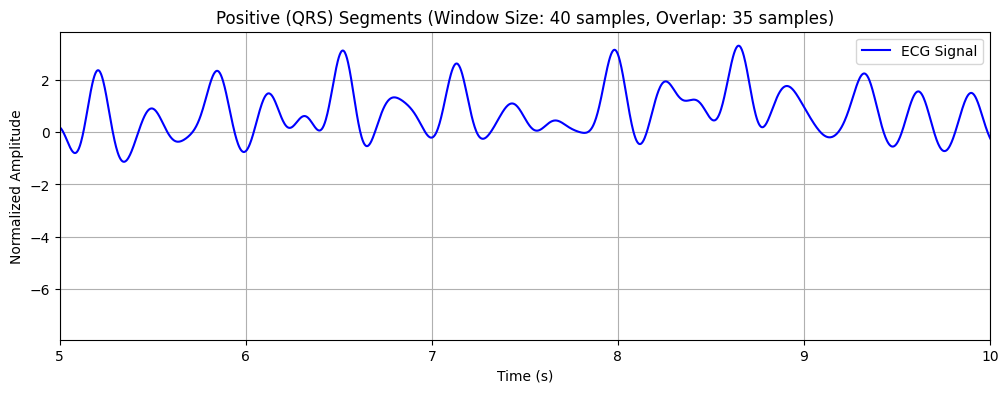

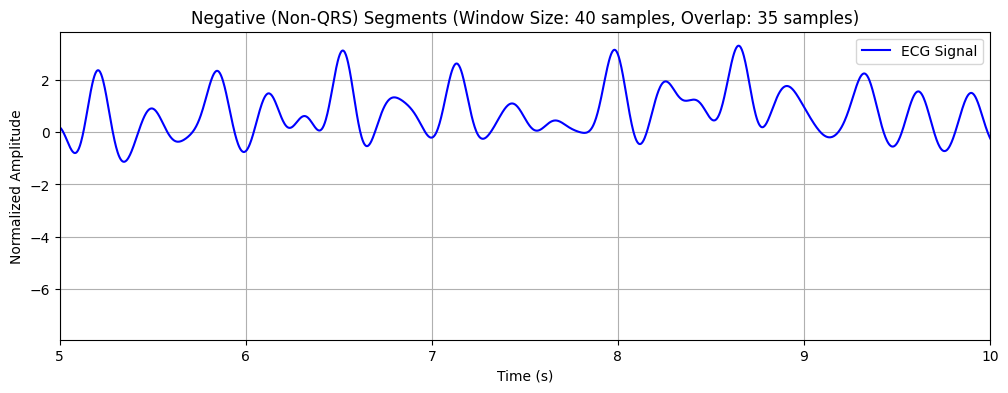

44 positive: 77, negative: 77
Processing record: 45 from but-pdb
Number of positive (QRS) segments: 135
Number of negative (non-QRS) segments: 135


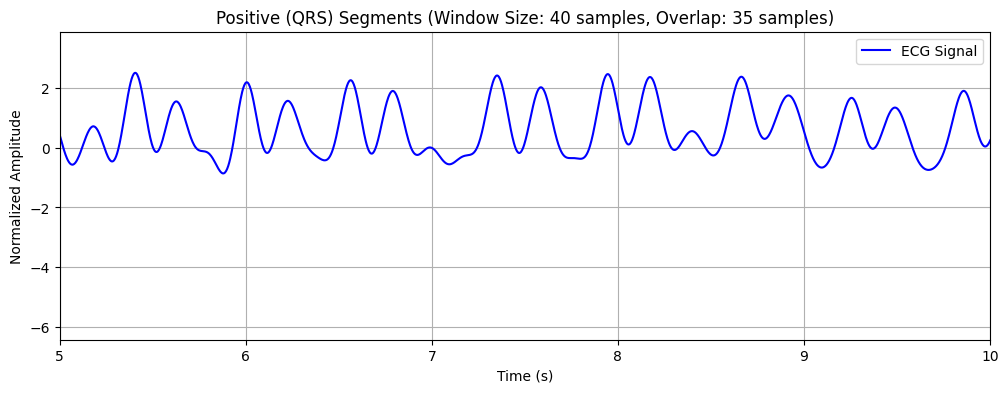

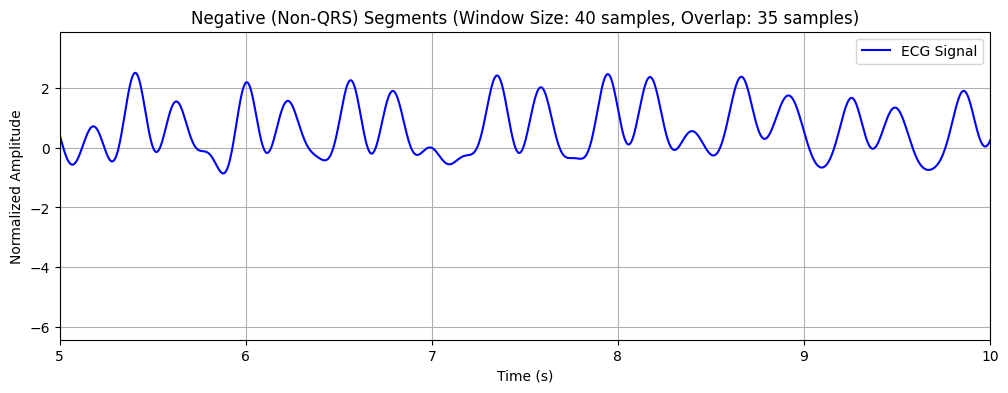

45 positive: 135, negative: 135
Processing record: 46 from but-pdb
Number of positive (QRS) segments: 59
Number of negative (non-QRS) segments: 59


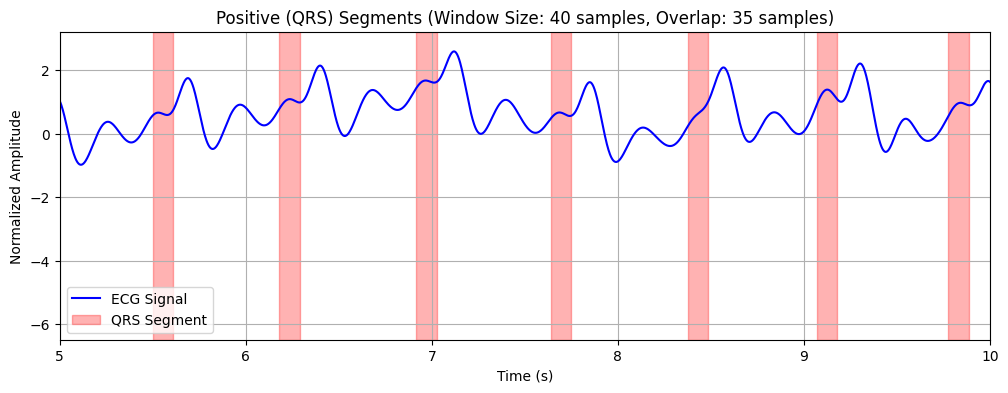

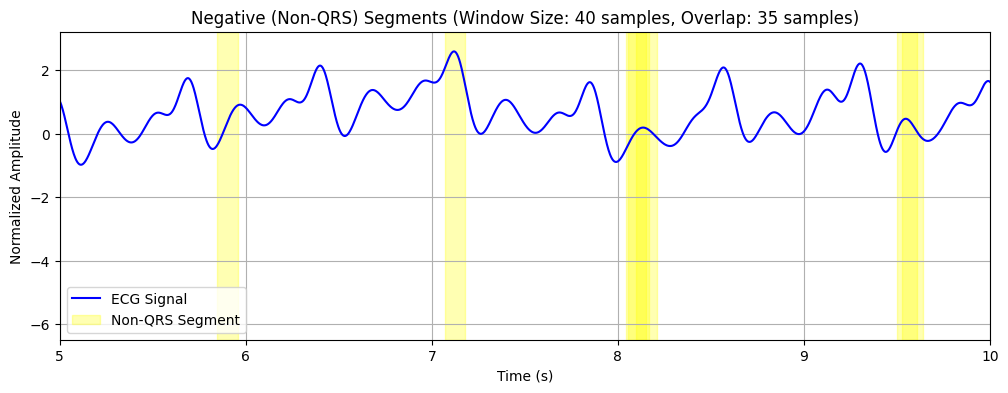

46 positive: 59, negative: 59
Processing record: 47 from but-pdb
Number of positive (QRS) segments: 36
Number of negative (non-QRS) segments: 36


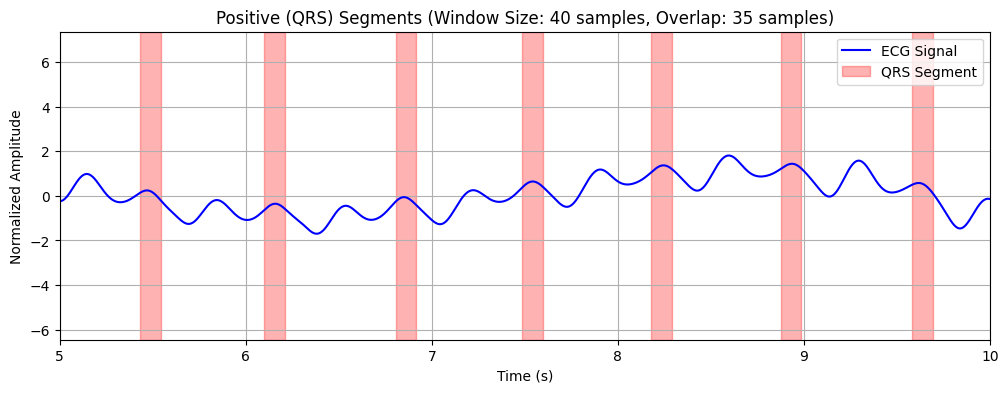

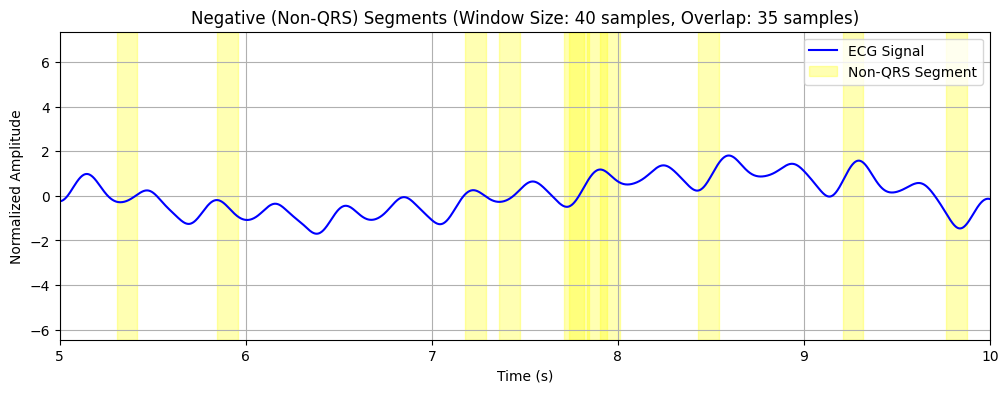

47 positive: 36, negative: 36
Processing record: 48 from but-pdb
Number of positive (QRS) segments: 1
Number of negative (non-QRS) segments: 0


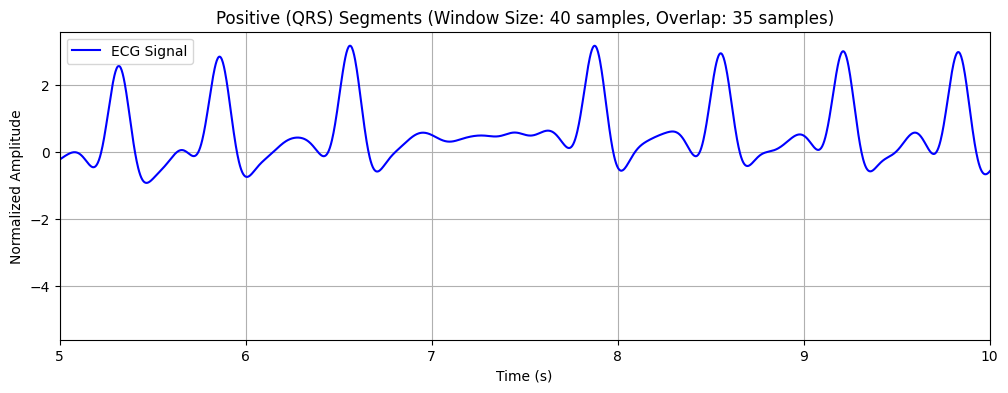

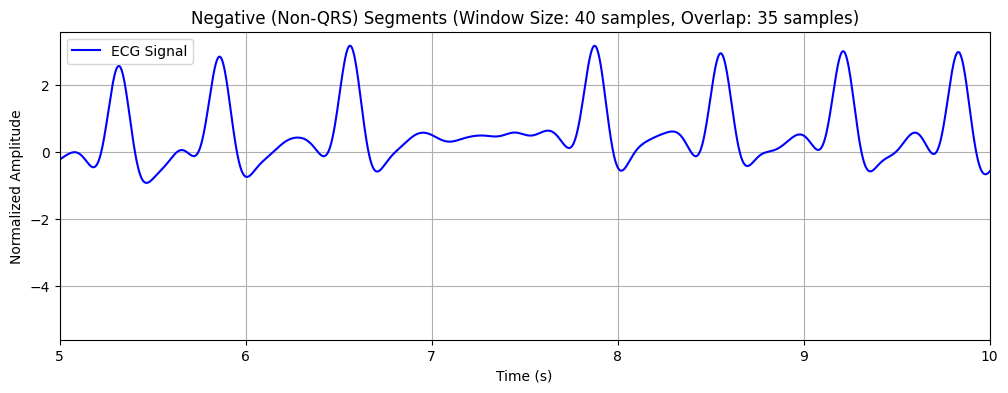

48 positive: 1, negative: 0
Processing record: 49 from but-pdb
Number of positive (QRS) segments: 87
Number of negative (non-QRS) segments: 87


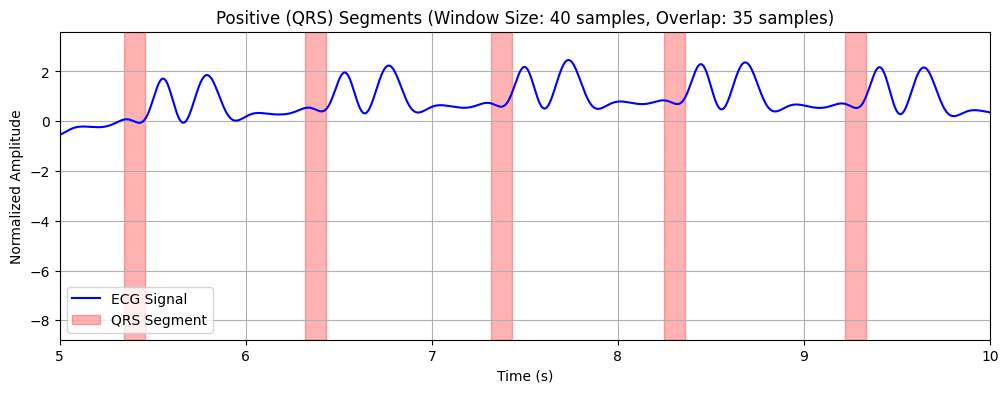

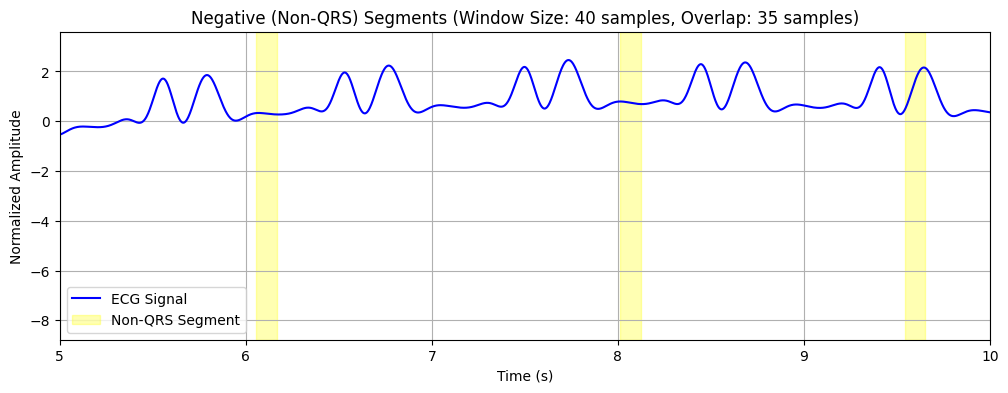

49 positive: 87, negative: 87
Processing record: 50 from but-pdb
Number of positive (QRS) segments: 6
Number of negative (non-QRS) segments: 6


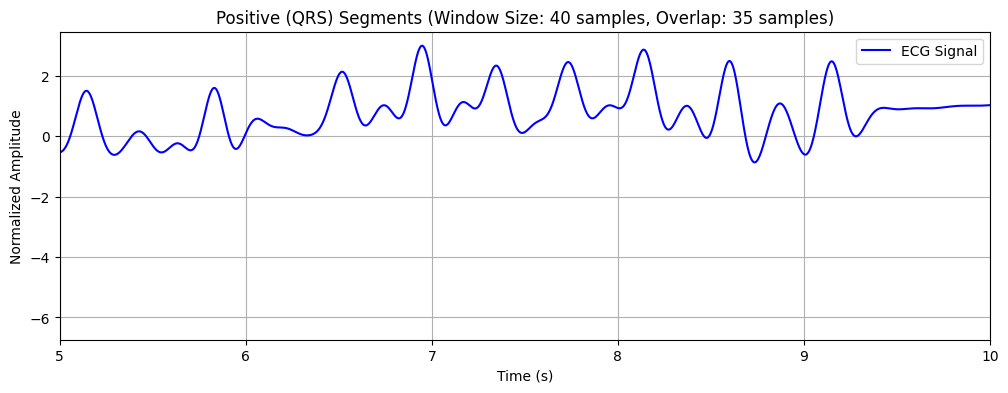

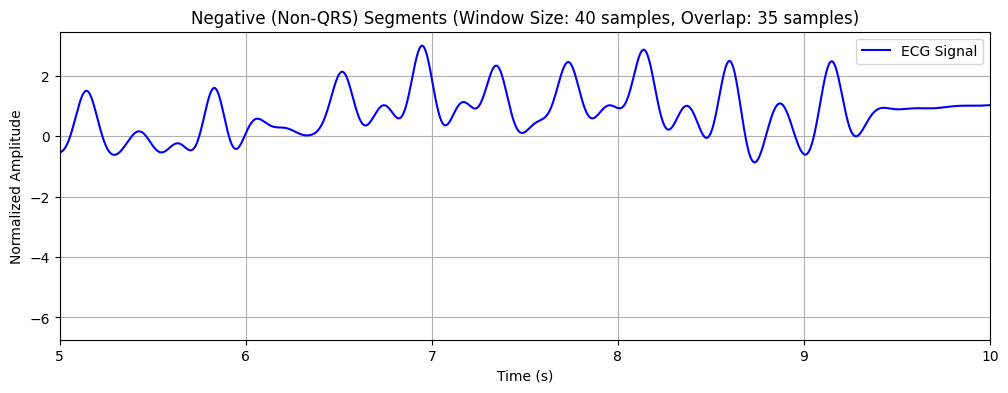

50 positive: 6, negative: 6
Total segments collected: 251948


In [ ]:
import wfdb
import numpy as np
from scipy.signal import resample

import wfdb
import numpy as np
from scipy.signal import resample

# Define record directories
db_paths = {
    #'ludb': '/content/physionet.org/files/ludb/1.0.1/',
    #'mitdb': '/content/physionet.org/files/mitdb/1.0.0/',
    #'qtdb': '/content/physionet.org/files/qtdb/1.0.0/',
    #'pwave' : '/content/physionet.org/files/pwave/1.0.0/',
    'but-pdb' : '/content/physionet.org/files/but-pdb/1.0.0/'

}

# Fetch record lists
record_lists = {
    db: wfdb.get_record_list(db) for db in db_paths
}

for i in range(9):
  record_lists['but-pdb'][i]='0'+record_lists['but-pdb'][i]


# Process all records in all databases
for db_name, record_dir in db_paths.items():
    for record_name in record_lists[db_name]:
        print(f"Processing record: {record_name} from {db_name}")

        # Load signal
        record = wfdb.rdrecord(record_dir + record_name)
        try:
          if db_name == 'ludb' :
            annotation = wfdb.rdann(record_dir + record_name, 'i')
          elif db_name == 'qtdb' :
            annotation = wfdb.rdann(record_dir + record_name, 'pu0')
          else :
            annotation = wfdb.rdann(record_dir + record_name, 'pwave')
        except:
            print(f"No annotation found for {record_name}, skipping.")
            continue

        ecg_signal = record.p_signal[:, 0]
        G_fs = record.fs

        time_axis = np.arange(0, len(ecg_signal)) / G_fs

        # Apply bandpass filter and smoothing
        filtered_signal = bandpass_filter(ecg_signal, 1000)
        smoothed_signal = smooth_signal(filtered_signal, window_size=5)

        # Normalize and segment
        normalized_signal = normalize_signal(smoothed_signal)
        # Extract annotation labels (adjust if needed for LUDB/QTDB)
        if db_name == 'but-pdb':
          qrs_symbols = ['N']
        else :
          qrs_symbols = ['p']

        qrs_indices = [s for s, sym in zip(annotation.sample, annotation.symbol) if sym in qrs_symbols]

        if G_fs != 360:
            normalized_signal = resample_signal(normalized_signal, original_fs=G_fs, target_fs=360)
            qrs_indices = [adjust_annotation(point, original_fs=G_fs, target_fs=360) for point in qrs_indices]
            G_fs = 360

        # Segment the normalized signal
        segmented_signal, segment_starts = segment_signal(normalized_signal, window_size=G_window_size, overlap=G_overlap)


        # Label and clean
        segment_labels = label_segments(normalized_signal, segmented_signal, segment_starts, qrs_indices, q_offset=G_q_offset, window_size=G_window_size, overlap=G_overlap)
        segment_labels, segmented_signal, segment_starts = remove_consecutive_ones(segment_labels, segmented_signal, segment_starts)
        segment_labels, segmented_signal, segment_starts = trim_to_ones(segment_labels, segmented_signal, segment_starts)
        segment_labels, segmented_signal, segment_starts = remove_touching_negatives(segment_labels, segmented_signal, segment_starts)
        #display_segment(normalized_signal,segment_labels,segment_starts,0,10)
        segment_labels, segmented_signal, segment_starts = balance_classes(segment_labels, segmented_signal, segment_starts)
        #if record_name==record_lists[db_name][-1] or record_name==record_lists[db_name][0]:
        display_segment(normalized_signal,segment_labels,segment_starts,5,10)
        print(f"{record_name} positive: {np.sum(np.array(segment_labels) == 1)}, negative: {np.sum(np.array(segment_labels) == 0)}")

        '''
        np.savez("/content/drive/MyDrive/Final project/QRS detection/segments/"+record_name+" from "+db_name+" segment 70s 65o 33q.npz",
                segments=np.array(segmented_signal, dtype=object),
                labels=np.array(segment_labels),
                starts=np.array(segment_starts))
        '''
        # Store all data
        #all_segments.extend(segmented_signal)
        #all_segment_labels.extend(segment_labels)
        #all_segment_starts.extend(segment_starts)

print(f"Total segments collected: {len(all_segments)}")

In [ ]:
print(f"Total segments collected: {len(all_segments)}")

Total segments collected: 251948


In [ ]:
import numpy as np

# save segments

np.savez("P waves ludb qtdb segments 360hz 40s 30o 14q",
         segments=np.array(all_segments, dtype=object),
         labels=np.array(all_segment_labels),
         starts=np.array(all_segment_starts))

!cp '/content/P waves ludb qtdb segments 360hz 40s 30o 14q.npz' '/content/drive/MyDrive/Final project/QRS detection/segments/P waves ludb qtdb segments 360hz 40s 30o 14q.npz'

In [ ]:
import numpy as np
## load segments
data = np.load("/content/drive/MyDrive/Final project/QRS detection/segments/P waves ludb qtdb segments 360hz 40s 30o 14q.npz", allow_pickle=True)
#
## Extract lists
all_segments = data["segments"].tolist()
all_segment_labels = data["labels"].tolist()
all_segment_starts = data["starts"].tolist()
#
print("Data loaded successfully!")
print(len(all_segments))
print(len(all_segment_labels))
print(len(all_segment_starts))


Data loaded successfully!
251948
251948
251948


# 3-data Traitement

In [ ]:
segment_labels = np.array(all_segment_labels)
segmented_signal = np.array(all_segments)
segment_starts = np.array(all_segment_starts)

## A. Shuffle and Reshape Data

In [ ]:
from sklearn.utils import shuffle
import numpy as np

# Shuffle the data
all_segments, all_labels = shuffle(segmented_signal, segment_labels, random_state=42)
# Reshape to (num_samples, window_length, 1)
all_segments = all_segments.reshape(all_segments.shape[0], all_segments.shape[1], 1)
print("Reshaped data for CNN+LSTM:", all_segments.shape)
# Ensure all_labels is a 1D array
all_labels = np.array(all_labels).flatten()  # Convert to 1D array if it's not already
print("Shape of all_labels:", all_labels.shape)

# Separate positive and negative segments
positive_segments = all_segments[all_labels == 1]  # Index using the 1D boolean array
negative_segments = all_segments[all_labels == 0]

print ("positive segments:",positive_segments.shape)
print ("negative segments:",negative_segments.shape)


# Combine balanced positive and negative segments
balanced_segments = np.concatenate([positive_segments, negative_segments])
balanced_labels = np.concatenate([np.ones(len(positive_segments)), np.zeros(len(negative_segments))])
print(len(balanced_segments),len(balanced_labels))
# Shuffle the balanced dataset
balanced_segments, balanced_labels = shuffle(balanced_segments, balanced_labels, random_state=42)

# Reshape to (num_samples, window_length, 1)
balanced_segments = balanced_segments.reshape(balanced_segments.shape[0], balanced_segments.shape[1], 1)
print("Balanced data shape:", balanced_segments.shape)

Reshaped data for CNN+LSTM: (251948, 40, 1)
Shape of all_labels: (251948,)
positive segments: (125975, 40, 1)
negative segments: (125973, 40, 1)
251948 251948
Balanced data shape: (251948, 40, 1)


## B. Split

In [ ]:
from sklearn.model_selection import train_test_split

# Split into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(balanced_segments, balanced_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (151168, 40, 1) (151168,)
Validation: (50390, 40, 1) (50390,)
Test: (50390, 40, 1) (50390,)


In [ ]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)


Shape of X_train: (151168, 40, 1)
Shape of y_train: (151168,)


In [ ]:
# Reshape y_train, y_val, and y_test to match the model's output shape
y_train = y_train.reshape(-1, 1, 1)  # Shape: [num_samples, 1, 1]
y_val = y_val.reshape(-1, 1, 1)      # Shape: [num_samples, 1, 1]
y_test = y_test.reshape(-1, 1, 1)    # Shape: [num_samples, 1, 1]

# Verify shapes
print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (151168, 40, 1) (151168, 1, 1)
Validation: (50390, 40, 1) (50390, 1, 1)
Test: (50390, 40, 1) (50390, 1, 1)


In [ ]:
import numpy as np

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
print("NaN in X_train:", np.isnan(X_train).any())
print("Inf in X_train:", np.isinf(X_train).any())
print("NaN in y_train:", np.isnan(y_train).any())
print("Inf in y_train:", np.isinf(y_train).any())

NaN in X_train: False
Inf in X_train: False
NaN in y_train: False
Inf in y_train: False


# 4- Build the Hybrid CNN + LSTM Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, BatchNormalization, Flatten, Reshape,
    Bidirectional, LSTM, Dense, Dropout, TimeDistributed
)
# Parameters
window_length = G_window_size  # Fixed window length (e.g., 250 samples)
input_shape = (window_length, 1)  # Input shape: (batch_size, 250, 1)

# Define the CNN + LSTM model architecture
model = Sequential()

# --- CNN layers ---
# Input shape: (250, 1)
model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

# Second Conv1D layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

# Third Conv1D layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

# --- Flatten and reshape for LSTM ---
model.add(Flatten())

# Automatically calculate the flattened shape
flattened_shape = model.output_shape[1]  # Get the shape after Flatten
print(f"Flattened shape: {flattened_shape}")

# Reshape to (timesteps, features) for LSTM
model.add(Reshape((1, flattened_shape)))  # Reshape dynamically

model.add(Bidirectional(LSTM(units=100, return_sequences=False)))  # No need for return_sequences=True

# --- Fully Connected Layers ---
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))

# --- Output Layer ---
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()# Binary classification (QRS vs. non-QRS)


Flattened shape: 384


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 36, 32)              │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 18, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 18, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 16, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 8, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 6, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 3, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 1, 384)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 200)                 │         388,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │          10,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 430,101 (1.64 MB)

 Trainable params: 429,653 (1.64 MB)

 Non-trainable params: 448 (1.75 KB)

# 5- Train the Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Train Model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64,
          callbacks=[early_stopping, lr_scheduler])



Epoch 1/20
2362/2362 ━━━━━━━━━━━━━━━━━━━━ 61s 23ms/step - accuracy: 0.8951 - loss: 0.2577 - val_accuracy: 0.9312 - val_loss: 0.1727 - learning_rate: 0.0010
Epoch 2/20
2362/2362 ━━━━━━━━━━━━━━━━━━━━ 55s 23ms/step - accuracy: 0.9337 - loss: 0.1721 - val_accuracy: 0.9409 - val_loss: 0.1490 - learning_rate: 0.0010
Epoch 3/20
2362/2362 ━━━━━━━━━━━━━━━━━━━━ 82s 23ms/step - accuracy: 0.9428 - loss: 0.1516 - val_accuracy: 0.9485 - val_loss: 0.1355 - learning_rate: 0.0010
Epoch 4/20
2362/2362 ━━━━━━━━━━━━━━━━━━━━ 82s 23ms/step - accuracy: 0.9457 - loss: 0.1442 - val_accuracy: 0.9439 - val_loss: 0.1435 - learning_rate: 0.0010
Epoch 5/20
2362/2362 ━━━━━━━━━━━━━━━━━━━━ 82s 23ms/step - accuracy: 0.9479 - loss: 0.1375 - val_accuracy: 0.9506 - val_loss: 0.1273 - learning_rate: 0.0010
Epoch 6/20
2362/2362 ━━━━━━━━━━━━━━━━━━━━ 81s 22ms/step - accuracy: 0.9497 - loss: 0.1331 - val_accuracy: 0.9505 - val_loss: 0.1284 - learning_rate: 0.0010
Epoch 7/20
2362/2362 ━━━━━━━━━━━━━━━━━━━━ 82s 22ms/step - accura

# 6- Evaluate and Test the Model

In [ ]:
from sklearn.metrics import classification_report

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
# Flatten y_test and y_pred to 1D arrays
y_test_flat = y_test.reshape(-1)  # Shape: (num_samples,)
y_pred_flat = y_pred.reshape(-1)  # Shape: (num_samples,)

# Print classification report
print(classification_report(y_test_flat, y_pred_flat))

1575/1575 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     25198
         1.0       0.97      0.95      0.96     25192

    accuracy                           0.96     50390
   macro avg       0.96      0.96      0.96     50390
weighted avg       0.96      0.96      0.96     50390



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test_flat, y_pred_flat)
recall = recall_score(y_test_flat, y_pred_flat)
f1 = f1_score(y_test_flat, y_pred_flat)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Precision: 0.9667
Recall: 0.9500
F1-Score: 0.9583


In [ ]:
from keras.saving import save_model

# Save the trained model
save_model(model,"/content/drive/MyDrive/Final project/QRS detection/P_cnn_lstm_model_70sample_MITDB_LUDB_QTDB.keras")
model.save("/content/drive/MyDrive/Final project/QRS detection/P_cnn_lstm_model_70sample_MITDB_LUDB_QTDB.h5")


# 7- Model Test

In [ ]:
from tensorflow.keras.models import load_model
# Load the model later for inference
model = load_model("/content/drive/MyDrive/Final project/QRS detection/P_cnn_lstm_model_70sample_MITDB_LUDB_QTDB.h5")

In [ ]:
!wget -r -N -c -np https://physionet.org/files/edb/1.0.0/

250
360


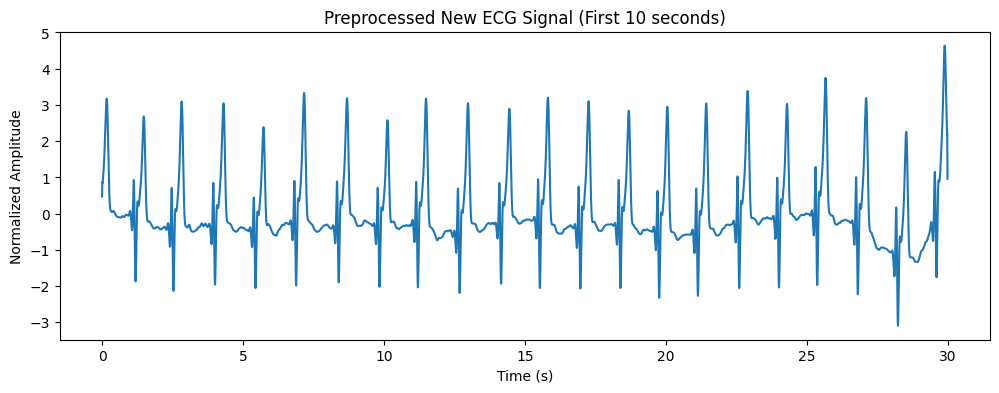

In [ ]:
import wfdb
import numpy as np
record_dir='/content/drive/MyDrive/Final project/dataset/physionet.org/files/edb/1.0.0/'
# Load a new ECG signal (example: another record from MIT-BIH)
# Load a new ECG signal (example: another record from MIT-BIH)
new_record_name='e1301'
new_record_name =  record_dir + new_record_name  # Change this to the desired record
new_record = wfdb.rdrecord(new_record_name)
new_ecg_signal = new_record.p_signal[:, 0]  # Assuming single-channel ECG
G_fs = new_record.fs
print(G_fs)
new_ecg_signal = new_ecg_signal[int(30 * G_fs):int(60 * G_fs)]
# Example usage
time_axis = np.arange(0, len(new_ecg_signal)) / G_fs  # Time axis in seconds

# Optionally smooth the signal
new_normalized_signal = normalize_signal(smooth_signal(bandpass_filter(new_ecg_signal, 1000), window_size=5))
if G_fs != 360:
            new_normalized_signal = resample_signal(new_normalized_signal, original_fs=G_fs, target_fs=360)
            G_fs = 360

print(G_fs)
# Visualize the preprocessed signal
import matplotlib.pyplot as plt
time_axis = [i / G_fs for i in range(len(new_normalized_signal))]
plt.figure(figsize=(12, 4))
#plt.plot(time_axis[:G_fs * 10], new_normalized_signal[:G_fs * 10])
plt.plot(time_axis, new_normalized_signal)
plt.title("Preprocessed New ECG Signal (First 10 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Amplitude")
plt.show()



In [ ]:



# Segment the normalized signal
new_segments,new_start_segments = segment_signal(new_normalized_signal, window_size=G_window_size, overlap=G_overlap)

print(f"Extracted {len(new_segments)} segments with window size {G_window_size} and {G_overlap} samples overlap.")



Extracted 2153 segments with window size 40 and 35 samples overlap.


In [ ]:
# Reshape segments for CNN+LSTM (adding a channel dimension)
new_segments_reshaped = new_segments.reshape(new_segments.shape[0], new_segments.shape[1], 1)

# Print the shape
print("Shape of input segments for model:", new_segments_reshaped.shape)


Shape of input segments for model: (2153, 40, 1)


In [ ]:
# Predict using the trained model
predictions = model.predict(new_segments_reshaped)

# Convert predictions to binary labels (threshold at 0.5)
predicted_labels = (predictions > 0.5).astype(int)

# Print results
print("Predicted QRS presence for each segment:", predicted_labels.flatten())


68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Predicted QRS presence for each segment: [0 0 0 ... 0 0 0]


## display results

Number of positive (QRS) segments: 127
Number of negative (non-QRS) segments: 2026


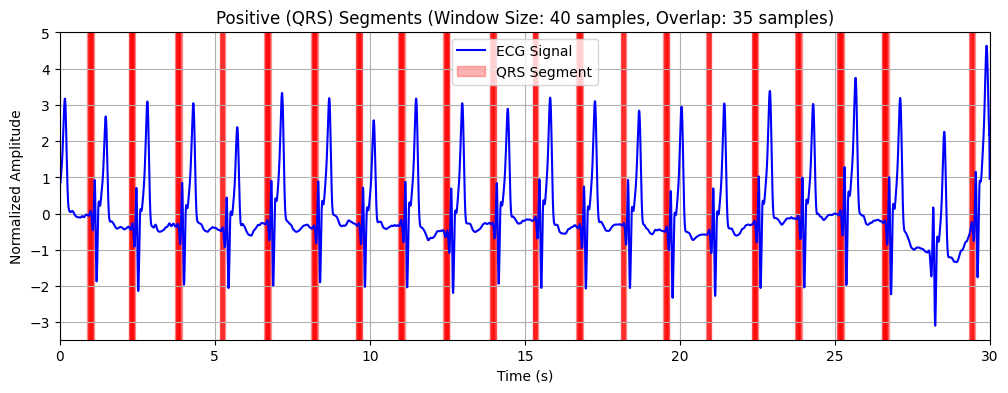

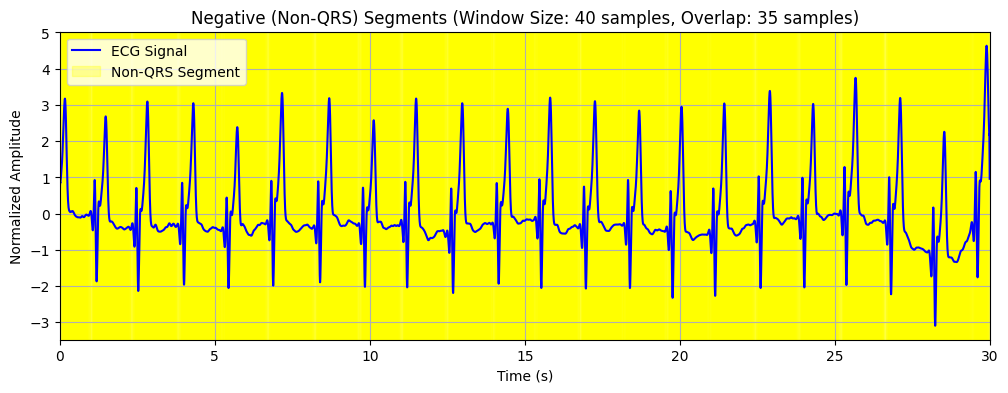

In [ ]:
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,len(new_normalized_signal)/G_fs)

Number of positive (QRS) segments: 127
Number of negative (non-QRS) segments: 2026


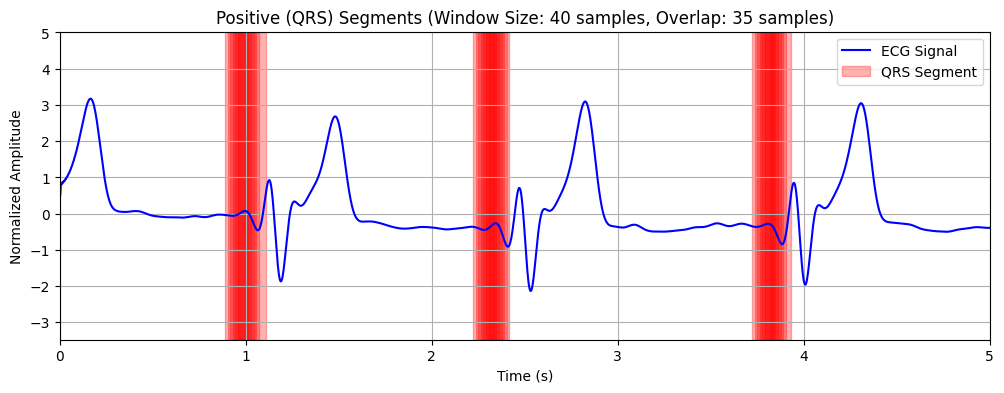

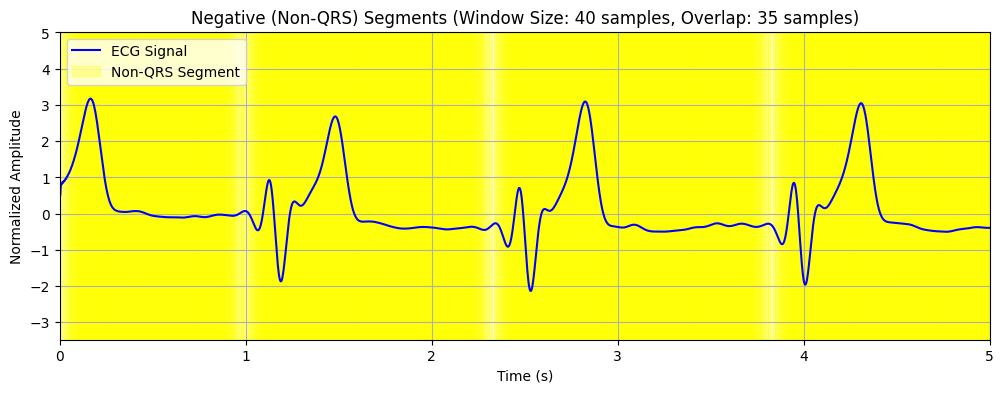

In [ ]:
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,5)

## Improvement

In [ ]:
def remove_short_qrs_predictions(segment_labels, segmented_signal, segment_starts, min_len=3):
    filtered_labels = []
    filtered_signal = []
    filtered_starts = []

    i = 0
    while i < len(segment_labels):
        if segment_labels[i] == 1:
            # Start of a 1-run
            start = i
            while i + 1 < len(segment_labels) and segment_labels[i + 1] == 1:
                i += 1
            end = i

            run_length = end - start + 1

            if run_length >= min_len:
                # Keep only the middle of a valid QRS run
                mid = (start + end) // 2
                filtered_labels.append(1)
                filtered_signal.append(segmented_signal[mid])
                filtered_starts.append(segment_starts[mid])
            else:
                # Discard this short run
                pass
        else:
            # Keep zeros as-is
            filtered_labels.append(0)
            filtered_signal.append(segmented_signal[i])
            filtered_starts.append(segment_starts[i])
        i += 1

    return filtered_labels, filtered_signal, filtered_starts


In [ ]:


predicted_labels, new_segments, new_start_segments = remove_consecutive_ones( predicted_labels, new_segments, new_start_segments)
predicted_labels, new_segments, new_start_segments = remove_touching_negatives( predicted_labels, new_segments, new_start_segments)
predicted_labels, new_segments, new_start_segments = remove_consecutive_ones( predicted_labels, new_segments, new_start_segments)
predicted_labels=np.array(predicted_labels)

#eval_new_signal(real_labels=real_labels,predicted_labels=predicted_labels)

In [ ]:
print(len(predicted_labels))
#print(len(real_labels))

1746


Number of positive (QRS) segments: 20
Number of negative (non-QRS) segments: 1726


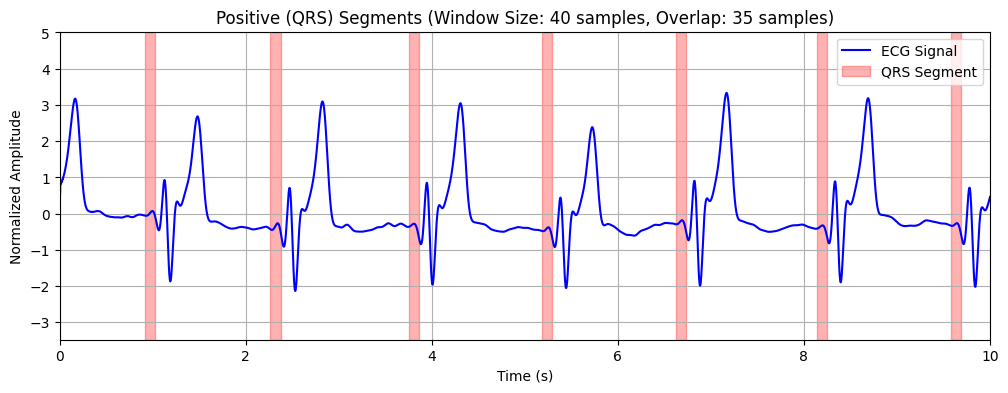

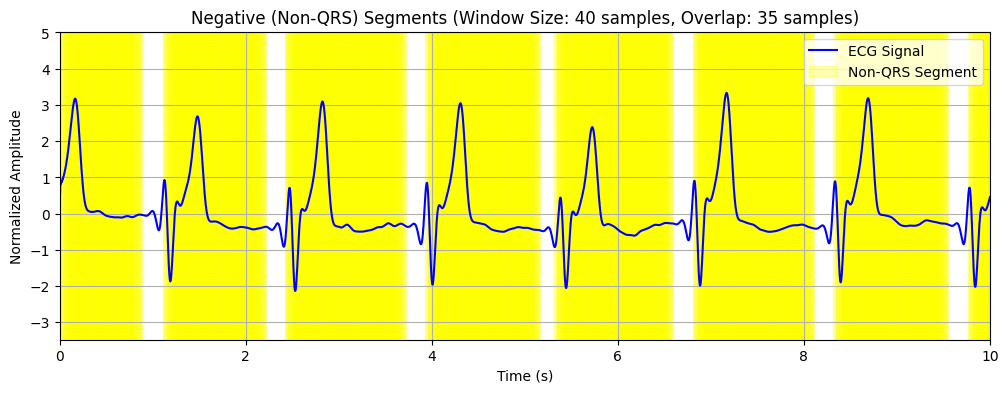

In [ ]:

display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,10)